### Projet Python pour l'Economiste (2A): Louise Bonhomme et Morgane Monjour

# Exporter du Champagne dans des Pays en Développement: étude des déterminants de l'importation de Champagne et des opportunités pour l'exportation

## Introduction et problématisation

Le 15 décembre 2021 a été ratifié un projet de fusion absorption  entre les 6000 vignerons de la Coopérative Régionale des Vins de Champagne (CRVC) et le Centre vinicole-Champagne Nicolas Feuillatte (CV-CNF), créant ainsi un nouveau géant du secteur.  Cette fusion répond à une stratégie internationale et à une volonté de peser davantage à l’export. Selon, Véronique Blin la présidente du CV-CNF les « gisements de croissance se trouvent à l’extérieur, sur des marchés plus lointains ».  En mettant leur moyens en commun Fabrice Colin le président de la CRVC entend « affronter les marchés de demain » qui se profilent donc davantage mondialisés.

Cet exemple nous laisse à penser que le Champagne, vin pétillant nommé après sa région de production, la Champagne située à l’Est de la France, est un produit dont les caractéristiques sont propices à l’exportation. En effet la production de champagne est régie par l’appellation d’origine contrôlée (AOC) « Champagne » qui ne peut être accordée qu’aux vins récoltés et entièrement manipulés dans les limites de la Champagne viticole. Ainsi pour consommer du Champagne hors de France il est nécessaire d’avoir recours à l’exportation.

Sans surprise, la France est le pays où l’on consomme le plus de Champagne mais en 2020, plus de la moitié des bouteilles produites ont été exportées. En 2020, près de 300 millions de bouteilles de Champagne ont été produites avec un chiffre d’affaires de 5 milliards d’euros. Environ la moitié  (près de 156 millions de bouteilles) a été expédiée dans le monde pour un chiffre d’affaires de 3 milliards d’euros. Le premier marché extérieur est le Royaume-Uni avec une consommation de près de 27 millions de bouteilles exportées en 2020, suivi des Etats Unis avec près de 26 millions de bouteilles exportées. Puis viennent le Japon (14 millions), l’Allemagne (12 millions), la Belgique (9 millions). 

Ainsi, il apparaît que les premiers exportateurs et consommateurs de Champagne sont les pays développés mais dans de nombreux pays en développement qui ont vu l’émergence d’une classe moyenne, un marché pour la consommation du champagne prend forme. Des lors, en adoptant le point de vue d'un producteur de Champagne souhaitant exporter on cherchera à mettre en lumière les pays en développement dans lesquels ce dernier aurait le plus intérêt à exporter. 

Tout d'abord on montrera dans quelle mesure le Champagne est un produit dont la consommation est mondialisée (partie I). Ensuite, on cherchera à comprendre quels sont les déterminants des importations de Champagne (partie II) avant d'identifier les pays en développement dans lesquels il y a les meilleures opportunités pour un exportateur de Champagne (partie III). 

### Importation de tous les packages que nous allons utiliser

In [122]:
#!pip install tabula-py

In [123]:
#!pip install ipywidgets

In [124]:
#Importations des packages nécessaires

import numpy as np

#Dataframe 
import pandas as pd

#Scraping 
import bs4
import urllib
from urllib import request
import urllib.parse
import urllib.request
import tabula as tb
import ssl

#Graphiques
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import folium
import geopandas
import geopy
from time import sleep
import ipywidgets as widgets

#Statistiques et économétrie
import seaborn as sns
import statsmodels.api as sm

# Collecte des bases de données (Webscraping)

Nous faisons le choix de "scraper" toutes nos données (à l'exception d'une table pour laquelle cela n'a pas été possible) dans un soucis de reproductibilité et d'accessibilité. 

# 0- Valeur des exportations de Champagne dans les différents pays (en €)

On s'intéresse ici à la valeur en euros des bouteilles de Champagne expédiées par les producteurs de Champagne dans le monde en 2019. Comme l'appellation Champagne est protégée, il est certain que les expéditions de Champagne depuis la France correspondent finalement aux importations de Champagne dans les pays étrangers. On récupère ces données via un PDF fourni par le site officiel des maisons de Champagne.



#### Téléchargement du PDF
Le site dirige directement vers un pdf, qu'il va falloir télécharger. Or, l'adresse url ne peut être lue directement car tous les caractères ne sont pas des utf8. Après avoir modifié l'url, on peut télécharger le PDF. 

**ATTENTION**, ce code ne fonctionne que lorsqu'on est connecté à un **réseau privé** (par exemple, en étant connecté au réseau ENSAE, il ne fonctionne pas). 

*Dans le cas où le code ci-dessous ne fonctionnerait pas, il suffit d'exécuter directement la cellule de code suivante pour télécharger le PDF que nous fournissons sur git.*

In [125]:
##Téléchargement du pdf 

#Il faut créer un certificat pour accéder au site
ssl._create_default_https_context = ssl._create_unverified_context
url = 'https://www.champagne.fr/assets/files/economie/2019/bulletin_expéditions_2019.pdf'

#Changement du nom de l'url pour qu'il puisse être lu par la fonction urlretrieve
url = urllib.parse.urlsplit(url)
url = list(url)
url[2] = urllib.parse.quote(url[2])
url = urllib.parse.urlunsplit(url)

#Création du fichier champagne pdf contenant le pdf de l'url 
urllib.request.urlretrieve(url,'champagne.pdf')

('champagne.pdf', <http.client.HTTPMessage at 0x1297e67f0>)

#### Scraping des données d'exportations du champagne de la France vers les autres pays

On scrape ensuite le PDF (ce qui est différent du webscrapping).

Les pages 45 à 49 donnent accès à des données sur les exportations de champagne dans tous les pays: en volume et en valeur. On s'intéresse à la valeur des exportations de Champagne dans la mesure où c'est cette variable qui intéresse davantage le producteur de Champagne souhaitant exporter. 

Comme le format des tables n'est pas usuel, il faut dimensionner les pages pour pouvoir identifier les colonnes désirées à partir de la fonction ***td.read_pdf()***. Cela revient à poser une "grille" sur le PDF pour ensuite se positionner où l'on souhaite.

In [126]:
#Création de la table df_champagne
df_champagne=pd.DataFrame()
file="champagne.pdf"

#Scraping des pages 45 à 48 qui contiennent les tableaux
for i in range(45,49):
    df_champagne_new= tb.read_pdf(file, pages = i, area = (0, 0, 1000, 1000), columns =  [200,400,500], \
                    pandas_options={'header': None}, stream=True)[0]
    df_champagne_new=df_champagne_new.iloc[5:df_champagne_new.shape[0]-1,[0,3]]
    df_champagne=pd.concat([df_champagne,df_champagne_new])

#Scraping du continent Océanie: à part car la table ne fait pas toute la page
df_champagne_new= tb.read_pdf(file, pages = '49', area = (0, 0, 250, 1000), columns =  [200,400,500], \
            pandas_options={'header': None}, stream=True)[0]
df_champagne_new=df_champagne_new.iloc[3:,[0,3]]

#On ajoute la table Océanie, puis on renomme les colonnes et on réinitialise l'index
df_champagne=pd.concat([df_champagne,df_champagne_new])
df_champagne.columns=['Pays',"Importations de Champagne (€)"]
df_champagne.reset_index(inplace=True,drop=True)

#On doit changer la colonne 'Pays' pour les Etats-Unis afin de pouvoir l'inclure plus tard dans la table finale
df_champagne.iloc[(df_champagne[df_champagne['Pays']=='ETATS-UNIS']).index[0],0]='ÉTATS-UNIS'

df_champagne

,Pays,Importations de Champagne (€)
0,ALBANIE,693 673
1,ALLEMAGNE,203 280 078
2,ANDORRE,1 358 610
3,AUTRICHE,32 915 653
4,BÉLARUS,1 360 946
...,...,...
158,ZAMBIE,11 933
159,AUSTRALIE,113 531 876
160,FIDJI,513 217
161,NOUVELLE-ZÉLANDE,12 210 359


###  Si le scraping du PDF ci-dessus ne fonctionne pas 
Nous fournissons la table df_champagne au format csv.

In [127]:
#df_champagne=pd.read_csv('df_champagne.csv').drop('Unnamed: 0',axis=1,inplace=True)

## 1- Classement des pays importateurs de vin en valeur (en $)

On s'intéresse aux importations de vin dans les différents pays car ces importations peuvent être un bon indicateur de la propension à importer du Champagne. On peut supposer que les marchés où l'on importe déjà une quantité importante du vin présentent plus d'opportunités pour les producteurs de Champagne qui souhaitent développer leur produit à l'étranger.

In [128]:
#Scraping avec BeautifulSoup à partir du site 
url_top_wine_import="https://www.worldstopexports.com/top-wine-importing-countries/"
req = urllib.request.Request(
    url_top_wine_import, 
    data=None, 
    headers={
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
    }
)

request_text=request.urlopen(req).read()
page=bs4.BeautifulSoup(request_text, 'lxml')
tableau_countries=page.find('table', {'class':"tablepress tablepress-id-80"})

#Titres
table_head=tableau_countries.find_all('thead')
titles=table_head[0].get_text(separator=' ').strip().replace('Wine Imports (US$)','Wine_Imports(US$)').split()

#Corps du tableau
table_body=tableau_countries.find('tbody')
rows=table_body.find_all('tr')

#Création d'un dictionnaire qu'on remplit au fur et à mesure de la lecture des lignes 
dico_countries_top_import=dict()
for row in rows: 
    cols=row.find_all('td')
    col_text=[col.text.strip() for col in cols]
    if len(col_text)>0:
        dico_countries_top_import[col_text[0]]=col_text[1:]
df_import_ranking=pd.DataFrame.from_dict(dico_countries_top_import, orient='index')
df_import_ranking.columns=titles[1:]

#On ne conserve que la colonne d'importations du vin (pas son évolution entre 2019 et 2020)
df_import_ranking=df_import_ranking.iloc[:,:2]

#Modification des noms de colonnes et mise en majuscule des pays 
df_import_ranking.columns=["Country","Importations de vin ($)"]
df_import_ranking['Country']=df_import_ranking["Country"].str.upper()
df_import_ranking

,Country,Importations de vin ($)
1.,UNITED STATES,"$5,883,811,000"
2.,UNITED KINGDOM,"$4,396,922,000"
3.,GERMANY,"$2,949,214,000"
4.,CANADA,"$1,974,379,000"
5.,CHINA,"$1,827,259,000"
...,...,...
96.,BAHAMAS,"$7,129,000"
97.,ALGERIA,"$7,094,000"
98.,ARUBA,"$6,985,000"
99.,MONTENEGRO,"$6,725,000"


## 2-Part de vin dans la consommation d'alcool par personne (en %)

On s'intéresse ici à la structure de la consommation d'alcool par personne dans les différents pays plus en détail: on regarde la proportion de chaque type d'alcool dans la consommation totale d'alcool. 

In [129]:
#Scraping avec BeautifulSoup à partir du site Wikipédia
url_conso_alcool="https://en.wikipedia.org/wiki/List_of_countries_by_alcohol_consumption_per_capita"
request_text=request.urlopen(url_conso_alcool).read()
page=bs4.BeautifulSoup(request_text, 'lxml')
tableau_alcool=page.find('table', {'class':"wikitable sortable static-row-numbers plainrowheaders srn-white-background"})

#Corps du tableau 
table_body=tableau_alcool.find('tbody')
rows=table_body.find_all('tr')

#Création du dictionnaire que l'on remplit au fur et à mesure de la lecture des lignes 
dico_countries_alcool_conso=dict()
for row in rows: 
    cols=row.find_all('td')
    col_text=[col.text.strip() for col in cols]
    if len(col_text)>0:
        dico_countries_alcool_conso[col_text[0]]=col_text[1:]
df_alcool_conso=pd.DataFrame.from_dict(dico_countries_alcool_conso, orient='index')

#Titres
col_names=table_body.find_all('th')
col_names_ok=[row.get_text(separator=' ').strip().title() for row in col_names]

df_alcool_conso.columns=col_names_ok[1:]
df_alcool_conso

,Total,Recorded Consumption,Unrecorded Consumption,Beer (%),Wine (%),Spirits (%),Other (%),2020 Projection,2025 Projection
Estonia,16.9,15.8,1.1,32.7,7.4,50.3,9.6,11.5,11.9
Lithuania,15,13.8,1.2,43.6,7.3,37.1,12.1,14.4,13.9
Czech Republic,14.3,12.4,1.4,53.3,21.3,25.4,0,11.2,11.4
Seychelles,13.8,12.4,1.4,68.9,22.4,6.3,2.5,10.4,10.6
Germany,13.4,11.3,1.4,52.6,28.4,18.9,0,12.8,12.6
...,...,...,...,...,...,...,...,...,...
Bangladesh,0,0,0,,,,,0,0
Kuwait,0,0,0,,,,,0,0
Libya,0,0,0,,,,,0,0
Mauritania,0,0,0,,,,,0,0


On choisit de sélectionner uniquement la part de vin consommée dans la consommation totale d'alcool par personne car la consommation de vin est la plus susceptible de prédire la consommation de champagne.

In [130]:
#Conservation de la colonne de consommation de vin
df_vin_conso=df_alcool_conso[["Wine (%)"]]

#Réinitialisation de l'index (pour ne plus que ce soit les pays), changement de noms des colonnes et mise en majuscule des pays
df_vin_conso.reset_index(inplace=True)
df_vin_conso.columns=["Country"]+list(df_vin_conso.columns[1:])
df_vin_conso['Country']=df_vin_conso['Country'].str.upper()
df_vin_conso.columns=['Country',"Part de Vin dans la consommation d'alcool (%)"]

df_vin_conso

/var/folders/yz/j7zl8ck90j528mms2yj13vhc0000gn/T/ipykernel_53976/244927810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vin_conso['Country']=df_vin_conso['Country'].str.upper()


,Country,Part de Vin dans la consommation d'alcool (%)
0,ESTONIA,7.4
1,LITHUANIA,7.3
2,CZECH REPUBLIC,21.3
3,SEYCHELLES,22.4
4,GERMANY,28.4
...,...,...
184,BANGLADESH,
185,KUWAIT,
186,LIBYA,
187,MAURITANIA,


 ## 3- PIB par habitant en parité de pouvoir d'achat (en $)

On choisit de faire une moyenne du PIB par habitant en parité de pouvoir d'achat entre 2016 et 2020 afin de capturer au mieux le niveau de vie structurel dans un pays (en lissant ce qui relève de la conjoncture économique). Les PIB par habitant sont exprimés en dollar américain. 

In [131]:
#Lecture directe du fichier excel à partir de l'url d'accès
url="https://api.worldbank.org/v2/fr/indicator/NY.GDP.PCAP.PP.CD?downloadformat=excel"
df_pib_hab=pd.read_excel(url)

#On réarrange la table (les noms de colonnes sont à la troisième ligne)
df_pib_hab.columns=(df_pib_hab.iloc[2,:])

#Réinitialisation de l'index
df_pib_hab=df_pib_hab.iloc[3:,].reset_index(drop=True)

#Moyenne entre 2016 et 2020 des PIB/hab en PPA
df_pib_hab["PIB par habitant en PPA"]=(df_pib_hab).iloc[:,60:].mean(axis=1)

#On ne garde que les noms des pays, les codes pays et les moyennes du PIB
df_pib_hab=df_pib_hab[["Country Name","Country Code",'PIB par habitant en PPA']]


#Suppression des NaN, changement des noms de colonnes et mise en majusucule des pays 
df_pib_hab.dropna(inplace=True)
df_pib_hab.columns=["Pays","Code Pays"]+list(df_pib_hab.columns[2:])
df_pib_hab['Pays']=df_pib_hab['Pays'].str.upper()
df_pib_hab

,Pays,Code Pays,PIB par habitant en PPA
0,ARUBA,ABW,38241.073873
2,AFGHANISTAN,AFG,2070.478996
4,ANGOLA,AGO,6981.909404
5,ALBANIE,ALB,13328.275340
7,LE MONDE ARABE,ARB,14270.468485
...,...,...,...
260,SAMOA,WSM,6607.344637
261,KOSOVO,XKX,10927.555842
263,AFRIQUE DU SUD,ZAF,13892.636826
264,ZAMBIE,ZMB,3513.863190


## 4- Taux de pauvreté (en %)

Le taux de pauvreté est exprimé en pourcentage de la population totale et correspond à la proportion d'individus dont le revenu disponible est inférieur eu seuil national de pauvreté pour une année donnée. 

In [132]:
#Scraping avec BeautifulSoup à partir du site 
url_pauvrete="https://atlasocio.com/classements/economie/pauvrete/classement-etats-par-taux-de-pauvrete-monde.php"
request_text=request.urlopen(url_pauvrete).read()
page=bs4.BeautifulSoup(request_text, 'lxml')
tableau_pauvrete=page.find_all('table', {'class':"responsive-table-all alternative rang"})

#Corps
tbody=tableau_pauvrete[0].find('tbody')
rows=tbody.find_all('tr')

#Création d'un dictionnaire que l'on remplit au fur et à mesure de la lecture des lignes
dico_pauvrete=dict()
for i in range (len(rows)): 
    cols=rows[i].find_all('td')
    col_text=[col.text.strip() for col in cols]
    if len(col_text)>0:
        dico_pauvrete[i]=col_text[1:]
df_pauvrete=pd.DataFrame.from_dict(dico_pauvrete, orient='index')

#On ne conserve que la 6ème colonne, ie l'année 2018
df_pauvrete=df_pauvrete[[0,6]]

#Changement des noms des colonnes et mise en majuscule des pays
df_pauvrete.columns=["Pays","Taux de pauvreté (%)"]
df_pauvrete['Pays']=df_pauvrete['Pays'].str.upper()

df_pauvrete

,Pays,Taux de pauvreté (%)
0,SYRIE,"82,5(2014)"
1,SOUDAN DU SUD,"82,3(2016)"
2,MADAGASCAR,"70,7(2012)"
3,SURINAME,"70,0(2002)"
4,ZIMBABWE,"70,0(2017)"
...,...,...
179,KAZAKHSTAN,"2,5(2017)"
180,TAÏWAN,"1,5(2012)"
181,UKRAINE,"1,3"
182,MALAISIE,"0,4(2015)"


## 5- Taux d'inscription dans l'enseignement supérieur (en %)

On s'intéresse ici à la proportion d'inscriptions dans l'enseignement supérieur en pourcentage de la population ayant fini de l'école secondaire il y a moins de 5 ans. On choisit de prendre une moyenne entre 2016 et 2020 afin de capter le taux d'inscription dans l'enseignement supérieur structurel. 

In [133]:
#Lecture directe du fichier excel à partir de l'url d'accès
url_etudes = 'https://api.worldbank.org/v2/fr/indicator/SE.TER.ENRR?downloadformat=excel'
df_etudes_sup=pd.read_excel(url_etudes)

#On réarrange la table (les noms de colonnes sont à la troisième ligne)
df_etudes_sup.columns=df_etudes_sup.iloc[2,:]

#Réinitialisation de l'index
df_etudes_sup=df_etudes_sup.iloc[3:,].reset_index(drop=True)

#Moyenne entre 2016 et 2020 du taux d'inscription dans les études supérieures
df_etudes_sup["Taux d'inscription dans le supérieur (%)"]=(df_etudes_sup).iloc[:,60:].mean(axis=1)

#On ne garde que les noms des pays, les codes pays et les moyennes de taux d'inscription
df_etudes_sup=df_etudes_sup[["Country Name","Country Code","Taux d'inscription dans le supérieur (%)"]]

#Changement des noms de colonnes, suppression des NaN et mise en majuscule des pays 
df_etudes_sup.columns=['Pays',"Code Pays"]+list(df_etudes_sup.columns[2:])
df_etudes_sup.dropna(inplace=True)
df_etudes_sup['Pays']=df_etudes_sup['Pays'].str.upper()

df_etudes_sup

,Pays,Code Pays,Taux d'inscription dans le supérieur (%)
0,ARUBA,ABW,15.599210
2,AFGHANISTAN,AFG,10.124470
4,ANGOLA,AGO,9.336260
5,ALBANIE,ALB,57.662016
7,LE MONDE ARABE,ARB,32.411325
...,...,...,...
257,VIET NAM,VNM,28.592475
259,MONDE,WLD,38.668136
260,SAMOA,WSM,14.889525
263,AFRIQUE DU SUD,ZAF,22.738250


## 6- Importations totales en % du PIB

On s'intéresse au pourcentage des importations totales dans le PIB afin de voir si le pays est globalement dépendant des autres pays et du commerce internationale pour la consommation intérieure ou si il est plutôt autosuffisant. On choisit de prendre une moyenne entre 2016 et 2020 afin de capter un taux d'importations structurel en pourcentage du PIB. 

In [134]:
#Lecture directe du fichier excel à partir de l'url d'accès
url_importations = "https://api.worldbank.org/v2/fr/indicator/NE.IMP.GNFS.ZS?downloadformat=excel"
df_importations=pd.read_excel(url_importations)

#On réarrange la table (les noms de colonnes sont à la troisième ligne)
df_importations.columns=df_importations.iloc[2,:]

#Réinitialisation de l'index
df_importations=df_importations.iloc[3:,].reset_index(drop=True)

#Moyenne entre 2016 et 2020 des importations totales en % du PIB
df_importations["Importations totales en % du PIB"]=(df_importations).iloc[:,60:].mean(axis=1)

#On ne garde que les noms des pays, les codes pays et les moyennes des importations totales
df_importations=df_importations[["Country Name","Country Code","Importations totales en % du PIB"]]

#Changement des noms de colonnes, suppression des NaN et mise en majuscule des pays 
df_importations.dropna(inplace=True)
df_importations.columns=['Country','Code Pays']+[df_importations.columns[2]]
df_importations['Country']=df_importations['Country'].str.upper()

df_importations

,Country,Code Pays,Importations totales en % du PIB
0,ARUBA,ABW,72.100422
4,ANGOLA,AGO,25.620855
5,ALBANIE,ALB,44.106203
7,LE MONDE ARABE,ARB,39.286490
8,ÉMIRATS ARABES UNIS,ARE,72.171329
...,...,...,...
261,KOSOVO,XKX,54.377598
262,"YÉMEN, RÉP. DU",YEM,31.445522
263,AFRIQUE DU SUD,ZAF,26.215384
264,ZAMBIE,ZMB,35.769604


## 7- Global Peace Index

Le Global peace Index est un indice qui tente de classer les pays du monde selon leur degré de pacifisme. Les scores s'échelonnent environ de 1 à 4 et plus le score est faible plus le pays est pacifique. On utilise la moyenne de ce score entre 2015 et 2019.

In [135]:
#Scraping avec BeautifulSoup à partir du site Wikipédia
url_global_peace_index="https://fr.wikipedia.org/wiki/Global_Peace_Index"
request_text=request.urlopen(url_global_peace_index).read()
page=bs4.BeautifulSoup(request_text, 'lxml')
tableau_gpi=page.find_all('table', {'class':"wikitable sortable"})

#Corps
table_body=tableau_gpi[1].find('tbody')
rows=table_body.find_all('tr')

#Création d'un dictionnaire que l'on remplit au fur et à mesure de la lecture des lignes 
dico_gpi=dict()
for row in rows: 
    cols=row.find_all('td')
    col_text=[col.text.strip() for col in cols]
    if len(col_text)>0:
        dico_gpi[col_text[0]]=col_text[1:]
df_gpi=pd.DataFrame.from_dict(dico_gpi, orient='index')

#Titres
col_names=table_body.find_all('th')
col_names_ok=[row.get_text(separator=' ').strip().title() for row in col_names]
df_gpi.columns=col_names_ok[1:]

#On ne garde que les colonnes donnant le score du gpi entre 2016 et 2019
df_gpi=df_gpi.iloc[:,[1,3,5,7,9]]

#Conversion str à numérique (float)
df_gpi = df_gpi.apply(pd.to_numeric)

#Moyenne du score entre 2016 et 2019
df_gpi["Global Peace Index"]=(df_gpi).mean(axis=1)
df_gpi=df_gpi[["Global Peace Index"]]

#Réinitialisation de l'index, changement des noms de colonnes et mise en majusucule des pays
df_gpi.reset_index(inplace=True)
df_gpi.columns=["Pays"]+list(df_gpi.columns[1:])
df_gpi['Pays']=df_gpi['Pays'].str.upper()
df_gpi

,Pays,Global Peace Index
0,ISLANDE,1.1064
1,NOUVELLE-ZÉLANDE,1.2260
2,PORTUGAL,1.3214
3,AUTRICHE,1.2740
4,DANEMARK,1.2696
...,...,...
158,YÉMEN,3.4664
159,SYRIE,3.2326
160,SOUDAN DU SUD,3.5056
161,IRAK,3.6226


## 8- Part de musulmans par pays (en %)

On s'intéresse ici à un facteur d'ordre religieux en regardant la part des musulmans dans les pays, les musulmans consommant en moyenne moins d'alcool que les adeptes des autres religions.

In [136]:
#Scraping avec BeautifulSoup à partir du site Wikipédia
url_musulmans ="https://fr.wikipedia.org/wiki/Nombre_de_musulmans_par_pays"
request_text=request.urlopen(url_musulmans).read()
page=bs4.BeautifulSoup(request_text, 'lxml')
tableau_musulmans=page.find_all('table', {'class':"wikitable sortable"})

#Corps
table_body=tableau_musulmans[0].find('tbody')
rows=table_body.find_all('tr')

#Création d'un dictionnaire que l'on remplit au fur et à mesure de la lecture des lignes 
dico_musulmans=dict()
for row in rows: 
    cols=row.find_all('td')
    col_text=[col.text.strip() for col in cols]
    if len(col_text)>0:
        nom=str(col_text[0]).replace(',','').split()[0]
        dico_musulmans[nom]=col_text[1:]
df_musulmans=pd.DataFrame.from_dict(dico_musulmans, orient='index')

#Titres colonnes
col_names=table_body.find_all('th')
col_names_ok=[row.get_text(separator=' ').strip().title() for row in col_names]
df_musulmans.columns=col_names_ok[1:]

#Traitement: les données ne sont pas exactes (intervalles) et ne sont pas numériques 
#On remplace les ',' par '.' pour pouvoir les transformer en numérique
#avec une fonction lambda: on split les textes, s'il contient par exemple '11-13' on garde 13, puis on rejointe les parties
df_musulmans["Pourcentage De Musulmans (%)"]=df_musulmans["Pourcentage De Musulmans"].str.replace(',','.')
df_musulmans["Pourcentage De Musulmans (%)"]=df_musulmans["Pourcentage De Musulmans (%)"].apply(lambda x: x[x.find('-')-1:]).apply(lambda x:''.join(i for i in str(x) \
                                                       if ((i.isdigit() or i=='.') and i!='-')))
#On ne conserve que le pourcentage de Musulmans
df_musulmans=df_musulmans[["Pourcentage De Musulmans (%)"]]

#Réinitialisation de l'index, changement des noms de colonnes, mise en majuscule des pays 
df_musulmans.reset_index(inplace=True)
df_musulmans.columns= ["Pays"]+list(df_musulmans.columns[1:])
df_musulmans['Pays']=df_musulmans['Pays'].str.upper()

df_musulmans

,Pays,Pourcentage De Musulmans (%)
0,AFGHANISTAN,.7
1,AFRIQUE,.9
2,ALBANIE,.7
3,ALGÉRIE,98
4,ALLEMAGNE,6
...,...,...
210,VIÊT,.1
211,WALLIS-ET-FUTUNA,.1
212,YÉMEN,.2
213,ZAMBIE,1


## 10- Distance avec la France (en kilomètres)

On s'intéresse à la distance qui sépare les pays de la France dans la mesure où la distance peut être un déterminant du commerce entre la France et les autres pays. La distance physique peut aussi avoir une influence sur la distance culturelle entre les pays: par exemple la France est plus proche culturellement de ses voisins européens que des pays plus lointains. 

In [137]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

In [138]:
#Lecture d'un excel après son extraction d'un zip lié à l'url suivant
url="http://www.cepii.fr/%5C/distance/dist_cepii.zip"
http_response = urlopen(url)
zipfile = ZipFile(BytesIO(http_response.read()))
zipfile.extractall(path='.')
#Tous les fichiers sont extraits

#Lecture du fichier des distances
df_distance=pd.read_excel("dist_cepii.xls")

#Sélection des distances avec la France, puis l'on garde seulement la distance et le nom du pays
df_distance=df_distance[df_distance['iso_o']=='FRA']
df_distance=df_distance[["iso_d",'dist']]

#Réinitialisation de l'index et changement des noms de colonnes 
df_distance.reset_index(drop=True,inplace=True)
df_distance.columns=["Code Pays","Distance avec la France (km)"]

df_distance

,Code Pays,Distance avec la France (km)
0,ABW,7685.884
1,AFG,5590.381
2,AGO,6510.322
3,AIA,6710.570
4,ALB,1603.534
...,...,...
219,YUG,1449.718
220,ZAF,9353.552
221,ZAR,6049.656
222,ZMB,7604.841


## 11- Nombre d'arrivées de touristes par pays (par an)

On s'intéresse au nombre d'arrivées de touristes afin de capter l'attractivité du pays pour le touristes qui sont susceptibles de consommer du Champagne dans des hôtels, restaurants ou boîtes de nuit. Là-aussi nous calculons la moyenne entre 2016 et 2020.

In [139]:
#Lecture directe du fichier excel à partir de l'url d'accès
url="https://api.worldbank.org/v2/fr/indicator/ST.INT.ARVL?downloadformat=excel"
df_tourisme=pd.read_excel(url)

#On réarrange la table (les noms de colonnes sont à la troisième ligne)
df_tourisme.columns=df_tourisme.iloc[2,:]

#Réinitialisation de l'index
df_tourisme=df_tourisme.iloc[3:,].reset_index(drop=True)

#Moyenne entre 2016 et 2020 des arrivées de touristes 
df_tourisme["Nombre annuel de touristes"]=(df_tourisme).iloc[:,60:].mean(axis=1)

#On ne garde que les noms des pays, les codes pays et la moyenne des arrivées de touristes
df_tourisme=df_tourisme[["Country Name","Country Code","Nombre annuel de touristes"]]

#Changement des noms de colonnes, suppression des NaN et mise en majuscule des pays 
df_tourisme.dropna(inplace=True)
df_tourisme.columns=['Pays','Code Pays']+list(df_tourisme.columns[2:])
df_tourisme['Pays']=df_tourisme['Pays'].str.upper()

df_tourisme

,Pays,Code Pays,Nombre annuel de touristes
0,ARUBA,ABW,1.867250e+06
4,ANGOLA,AGO,2.735000e+05
5,ALBANIE,ALB,5.546750e+06
6,ANDORRE,AND,8.185000e+06
7,LE MONDE ARABE,ARB,1.053851e+08
...,...,...,...
259,MONDE,WLD,2.167084e+09
260,SAMOA,WSM,1.642500e+05
263,AFRIQUE DU SUD,ZAF,1.497425e+07
264,ZAMBIE,ZMB,1.075750e+06


## 12- Droits de douane sur le vin pétillant incluant le Champagne (en % de la valeur)

On s'intéresse à la moyenne des taxes sur la valeur (taxes ad valorem) prelevées sur les importations de vin pétillant par les pays lors d'échanges dans le cadre de l'Organisation Mondiale du Commerce. 

Nous avons été contraints de télécharger le fichier sur le site, puisque le site créé "sur mesure" la base de données en fonction des indicateurs selectionnés.

In [140]:
#Téléchargement de la table à partir du fichier excel téléchargé préalablement
df_taxes=pd.read_excel("DataExport_19_12_2021__13_1_30.xls")

#Changement des noms de colonnes 
df_taxes.columns=list(df_taxes.iloc[1,:])
df_taxes.columns=['Pays']+list(df_taxes.iloc[0,1:2])+list(df_taxes.columns[2:])

#Réarrangement des lignes
df_taxes=df_taxes.iloc[4:,:]

#Conversion en valeurs numériques des taxes
df_taxes['Average of AV Duties']=df_taxes['Average of AV Duties'].apply(pd.to_numeric)

#Tri par pays et par année, puis on garde seulement la dernière année pour laquelle on a la donnée pour chaque pays
df_taxes=df_taxes.sort_values(by=['Pays','Year'])
df_taxes=df_taxes.drop_duplicates(subset=['Pays'],keep='last')

#On ne garde que les pays et les taxes moyennes
df_taxes=df_taxes[['Pays','Average of AV Duties']]

#Changement des noms de colonnes et mise en majuscule des pays
df_taxes.columns=['Country', "Taxes de Douane (%)"]
df_taxes['Country']=df_taxes['Country'].str.upper()

df_taxes

,Country,Taxes de Douane (%)
4,ALBANIA,15.0
7,ALGERIA,30.0
10,ANGOLA,30.0
13,ANTIGUA AND BARBUDA,5.0
16,ARGENTINA,27.5
...,...,...
439,"VENEZUELA, BOLIVARIAN REPUBLIC OF",20.0
442,VIET NAM,50.0
445,YEMEN,NaN
448,ZAMBIA,25.0


## 13- Population totale par pays

On s'intéresse à la population totale par pays afin de capter la taille potentielle du marché pour la consommation de Champagne.

In [141]:
#Lecture directe du fichier excel à partir de l'url d'accès
url_pop_totale ="https://api.worldbank.org/v2/fr/indicator/SP.POP.TOTL?downloadformat=excel"
df_pop_totale=pd.read_excel(url_pop_totale)

#On réarrange la table
df_pop_totale.columns=df_pop_totale.iloc[2,:]

#Réinitialisation de l'index
df_pop_totale=df_pop_totale.iloc[3:,].reset_index(drop=True)

#Moyenne entre 2016 et 2020 de la population totale
df_pop_totale["Population totale"]=(df_pop_totale).iloc[:,60:].mean(axis=1)

#On ne garde que les noms des pays, les codes pays et la moyenne de la population totale
df_pop_totale=df_pop_totale[["Country Name","Country Code","Population totale"]]

#Changement des noms de colonnes et suppression des NaN
df_pop_totale.columns=["Pays",'Code Pays','Population totale']
df_pop_totale.dropna(inplace=True)

df_pop_totale

,Pays,Code Pays,Population totale
0,Aruba,ABW,105829.6
2,Afghanistan,AFG,37164231.8
4,Angola,AGO,30832121.0
5,Albanie,ALB,2861573.6
6,Andorre,AND,77142.2
...,...,...,...
261,Kosovo,XKX,1785980.2
262,"Yémen, Rép. du",YEM,28497918.8
263,Afrique du Sud,ZAF,57775375.4
264,Zambie,ZMB,17362752.2


## 14- Expatriés français à l'étranger

On s'intéresse au nombre d'expatriés français vivant à l'étranger en 2019. On peut supposer que les expatriés français sont plus amateurs de Champagne que la population locale. De plus, si nous n'avons pas pu collecter des données sur les expatriés d'autres nationalités notamment européennes, on peut supposer que le nombre d'expatriés français dans un pays est correlé positivement au nombre total d'expatriés occidentaux dans ce pays.

In [142]:
#Scraping avec BeautifulSoup à partir du site Wikipédia
url='https://fr.wikipedia.org/wiki/Français_établis_hors_de_France'
url = urllib.parse.urlsplit(url)
url = list(url)
url[2] = urllib.parse.quote(url[2])
url = urllib.parse.urlunsplit(url)
request_text=request.urlopen(url).read()
page=bs4.BeautifulSoup(request_text, 'lxml')
tableau_expats=page.find('table', {'class':"wikitable sortable"})

#Corps
table_body=tableau_expats.find('tbody')
rows=table_body.find_all('tr')

#Création d'un dictionnaire que l'on remplit au fur et à mesure de la lecture des lignes 
dico_expats=dict()
for row in rows: 
    cols=row.find_all('td')
    col_text=[col.text.strip() for col in cols]
    if len(col_text)>0:
        dico_expats[col_text[1]]=col_text[2:]
df_expats=pd.DataFrame.from_dict(dico_expats, orient='index')
df_expats=df_expats.iloc[:,[4]]

#Réinitialisation de l'index, changement des noms de colonnes et mise en majuscule des pays 
df_expats.reset_index(inplace=True)
df_expats.columns=['Pays',"Nombre d'expatriés français"]
df_expats['Pays']=df_expats['Pays'].str.upper()
df_expats

,Pays,Nombre d'expatriés français
0,ALGÉRIE,40 173
1,LIBYE,70
2,MAROC,53 824
3,TUNISIE,23 230
4,BÉNIN,3 727
...,...,...
157,TRINITÉ-ET-TOBAGO,323
158,URUGUAY,2 833
159,VENEZUELA,3 213
160,CANADA,99 289


## 15- Nombre de bouteilles de champagne expédiées en France et à l'étranger depuis 1950

On s'intéresse ici au nombre de bouteilles de champagnes expédiées en France et à l'Etranger de 1950 à 2020 afin de regarder la mondialisation du Champagne. Ces données ne vont pas être intégrées dans la base de donnée finale mais elles vont nous permettre de visualiser l'évolution des exportations de Champagne à l'aide d'un graphique.

In [143]:
#Scraping avec BeautifulSoup à partir du site
url_exp="https://maisons-champagne.com/fr/filiere/economie/la-champagne-viticole/article/expeditions-d-aujourd-hui-a-1844"
request_text=request.urlopen(url_exp).read()
page=bs4.BeautifulSoup(request_text, 'lxml')
tableau_exp=page.find('table')

#Corps
table_body=tableau_exp.find('tbody')
rows=table_body.find_all('tr')

#Création d'un dictionnaire que l'on remplit au fur et à mesure de la lecture des lignes 
dico_exp = dict()
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if len(cols) > 0 : 
        dico_exp[cols[0]] = cols[0:]
df_exp = pd.DataFrame.from_dict(dico_exp,orient='index')

#Mise en forme de la base
col_names = df_exp.iloc[0] 
df_exp = df_exp[1:] 
df_exp.columns = col_names

#On ne garde que les données pour la période allant de 1950 à 2020
df_exp=df_exp.iloc[1:71,0:3]

#On convertit en valeur numérique les variables d'intérêt
df_exp.iloc[:,0] = df_exp.iloc[:,0].str.replace(" ","").astype(int)
df_exp.iloc[:,1] = df_exp.iloc[:,1].str.replace(" ","").astype(int)
df_exp.iloc[:,2] = df_exp.iloc[:,2].str.replace(" ","").astype(int)

df_exp

Années,Années,En France,A l’Etranger
2019,2019,141609887,155967874
2018,2018,147023308,153833001
2017,2017,153841546,153472037
2016,2016,157954272,148082097
2015,2015,161822697,150708747
...,...,...,...
1954,1954,22153428,10824352
1953,1953,19477929,11100079
1952,1952,18651060,12076452
1951,1951,20750839,15507435


# Traitement des données: nettoyage et construction de la base de données
Cette étape est cruciale afin de pouvoir utiliser les données. L'objectif de cette étape est de n'avoir qu'une seule table contenant toutes les données scrapées précédemment et dont les observations correspondent aux pays. 

Les sous-étapes nécessaires sont donc les suivantes: 
- Avoir une colonne nommée 'Pays' et une colonne 'Code Pays' qui sont les mêmes pour chaque table. Cela nous permettra de joindre les tables pour n'en former qu'une. 
- Traiter chaque colonne informative afin de l'utiliser optimalement en lui assignant un bon type de la colonne (int, float, str). En effet, beaucoup de colonnes numériques sont de type Object, ie. des str ou un mélange de types.

## Première étape
- On télécharge une table qui va nous permettre de traduire de l'anglais au français les noms des pays, mais aussi d'avoir les codes des pays : cette table va être utile pour les tables 1 et 2 pour traduire les noms des pays qui sont en anglais (*df_import_ranking*,*df_vin_conso*)

In [144]:
#Lecture de la table contenant notamment: les pays en français, les pays en anglais et les codes des pays
pays_conversion=pd.read_csv("https://sql.sh/ressources/sql-pays/sql-pays.csv",header=None)
pays_conversion=pays_conversion.iloc[:,3:]
pays_conversion.columns=["Code Pays","Pays","Country"]

#Mises en majuscules des pays pour un bon fonctionnement de la jointure
pays_conversion['Pays']=pays_conversion['Pays'].str.upper()
pays_conversion['Country']=pays_conversion['Country'].str.upper()

#On jointe avec les pays ayant les noms des pays en anglais pour les mettre en français
df_import_ranking=pays_conversion.merge(df_import_ranking, on='Country').iloc[:,[0,3]]
df_vin_conso=pays_conversion.merge(df_vin_conso, on='Country').iloc[:,[0,3]]
df_taxes=pays_conversion.merge(df_taxes, on='Country').iloc[:,[0,3]]

- On ajoute le code du pays pour chaque table

In [145]:
#On ne garde maintenant que les pays en français et les codes pays 
pays_conversion=pays_conversion.iloc[:,:2]

#On jointe chaque table n'ayant pas de codes de pays avec pays_conversion et on supprime la colonne pays 
df_champagne=pays_conversion.merge(df_champagne,on='Pays')
df_pauvrete=pays_conversion.merge(df_pauvrete,on='Pays').drop(['Pays'],axis=1)
df_gpi=pays_conversion.merge(df_gpi,on='Pays').drop(['Pays'],axis=1)
df_musulmans=pays_conversion.merge(df_musulmans,on='Pays').drop(['Pays'],axis=1)
df_distance=pays_conversion.merge(df_distance,on='Code Pays').drop(['Pays'],axis=1)
df_importations=pays_conversion.merge(df_importations,on='Code Pays').drop(['Pays'],axis=1).drop(['Country'],axis=1)
df_expats=pays_conversion.merge(df_expats,on='Pays').drop(['Pays'],axis=1)

#On supprime la colonne Pays pour les autres aussi 
df_pib_hab.drop(['Pays'],axis=1,inplace=True)
df_tourisme.drop(['Pays'],axis=1,inplace=True)
df_etudes_sup.drop(['Pays'],axis=1,inplace=True)
df_pop_totale.drop(['Pays'],axis=1,inplace=True)

- On peut maintenant construire la nouvelle table comprenant toutes les données. 

In [146]:
#On jointe à gauche toutes les tables à partir de la table d'importations de Champagne
noms=[df_import_ranking,df_vin_conso,df_importations,df_tourisme,df_pop_totale,df_expats,df_pib_hab,df_pauvrete,df_etudes_sup,df_gpi,df_musulmans,df_distance,df_taxes]
df_final=df_champagne
i=0
for nom in noms:
    df_final=df_final.merge(nom,on='Code Pays',how='left')
df_final

,Code Pays,Pays,Importations de Champagne (€),Importations de vin ($),Part de Vin dans la consommation d'alcool (%),Importations totales en % du PIB,Nombre annuel de touristes,Population totale,Nombre d'expatriés français,PIB par habitant en PPA,Taux de pauvreté (%),Taux d'inscription dans le supérieur (%),Global Peace Index,Pourcentage De Musulmans (%),Distance avec la France (km),Taxes de Douane (%)
0,ALB,ALBANIE,693 673,"$12,416,000",26.5,44.106203,5546750.0,2861573.6,204,13328.275340,"14,3(2012)",57.662016,1.8876,.7,1603.5340,15.0
1,DZA,ALGÉRIE,372 364,"$7,094,000",24.4,31.383153,2379500.0,42214616.8,40 173,11720.187773,"5,5(2011)",49.351982,2.2106,98,1340.3900,30.0
2,AND,ANDORRE,1 358 610,"$12,812,000",42,NaN,8185000.0,77142.2,2 434,NaN,NaN,NaN,NaN,.6,711.5485,NaN
3,AGO,ANGOLA,1 503 468,"$34,377,000",17.6,25.620855,273500.0,30832121.0,1 550,6981.909404,"36,6(2008)",9.336260,2.0262,.3,6510.3220,30.0
4,AZE,AZERBAÏDJAN,611 289,NaN,36.9,39.263908,2741500.0,9933804.0,221,14514.059945,"4,9(2015)",29.498194,2.4390,.9,3817.5470,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,BFA,BURKINA FASO,1 285 067,"$7,784,000",2.7,32.089594,145500.0,19763142.6,3 687,2129.804184,"40,1(2014)",6.601418,2.0432,NaN,4082.8700,20.0
143,URY,URUGUAY,537 469,"$11,294,000",43.7,21.311474,3821250.0,3449106.4,2 833,23168.881461,"7,9(2017)",81.440138,1.7298,.1,10972.4200,20.0
144,UZB,OUZBÉKISTAN,744 325,NaN,8.6,34.122945,4203000.0,33001000.0,114,7256.128791,"14,0(2016)",11.244712,2.1766,.7,5153.0640,NaN
145,VEN,VENEZUELA,696 240,"$10,320,000",0.3,NaN,555000.0,29018523.6,3 213,NaN,"33,1(2015)",NaN,2.6066,.3,7618.8600,NaN


In [147]:
print("Somme des NaN:\n", df_final.isna().sum(),'\n')
print('Moyenne des NaN:',df_final.iloc[:,3:].isna().sum().mean())

Somme des NaN:
 Code Pays                                         0
Pays                                              0
Importations de Champagne (€)                     0
Importations de vin ($)                          63
Part de Vin dans la consommation d'alcool (%)    16
Importations totales en % du PIB                 13
Nombre annuel de touristes                       10
Population totale                                 1
Nombre d'expatriés français                      29
PIB par habitant en PPA                           9
Taux de pauvreté (%)                             29
Taux d'inscription dans le supérieur (%)         30
Global Peace Index                               35
Pourcentage De Musulmans (%)                     25
Distance avec la France (km)                      3
Taxes de Douane (%)                              62
dtype: int64 

Moyenne des NaN: 25.0


Finalement, nous remarquons que **147 pays** (sur 195 dans le monde) sont observés dans cette table. Il y a en moyenne 82% de données rapportées par variable (ie 122 pays) pour un minimum de 57% (ie 84 pays). Cela est tout à fait satisfaisant dans l'optique de régression.

### S'il y a un quelconque problème lors des étapes précédentes
Nous fournissons la table finale df_finale jointe, mais non traitée au format csv.

In [148]:
#df_final=pd.read_csv('df_final.csv').drop('Unnamed: 0',axis=1,inplace=True)

## Deuxième étape
- On veut maintenant faciliter l'utilisation des données en les convertissant au bon type.

In [149]:
#Types initiaux
df_final.dtypes

Code Pays                                         object
Pays                                              object
Importations de Champagne (€)                     object
Importations de vin ($)                           object
Part de Vin dans la consommation d'alcool (%)     object
Importations totales en % du PIB                 float64
Nombre annuel de touristes                       float64
Population totale                                float64
Nombre d'expatriés français                       object
PIB par habitant en PPA                          float64
Taux de pauvreté (%)                              object
Taux d'inscription dans le supérieur (%)         float64
Global Peace Index                               float64
Pourcentage De Musulmans (%)                      object
Distance avec la France (km)                     float64
Taxes de Douane (%)                              float64
dtype: object

- Traitement et changement des types de colonnes 

In [150]:
#On remplace les espaces par un vide -> int 
df_final["Importations de Champagne (€)"]=df_final["Importations de Champagne (€)"].str.replace(' ','').astype('int64')

#On remplace les '$' par un vide -> float
df_final['Importations de vin ($)']=df_final['Importations de vin ($)'].str.replace('$','').str.replace(',','').astype('float64')

#On remplace les cellules vides par des nan -> float
df_final["Part de Vin dans la consommation d'alcool (%)"]=df_final["Part de Vin dans la consommation d'alcool (%)"].replace('', np.nan).astype('float64')

#On supprime la date entre parenthèse pour ne garder que la valeur puis on remplace ',' par '.' -> float
df_final['Taux de pauvreté (%)']=df_final['Taux de pauvreté (%)'].apply(lambda x: str(x)[:-6]).replace('',np.nan).str.replace(',','.').astype('float64')

#Conversion directe en float
df_final['Pourcentage De Musulmans (%)']=df_final['Pourcentage De Musulmans (%)'].astype('float64')

#On "split" le texte pour transformer en str chaque partie et ensuite les joindre -> float
df_final["Nombre d'expatriés français"]=df_final["Nombre d'expatriés français"].apply(lambda x: ''.join((str(x).split()))).astype('float')

/var/folders/yz/j7zl8ck90j528mms2yj13vhc0000gn/T/ipykernel_53976/3172266943.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_final['Importations de vin ($)']=df_final['Importations de vin ($)'].str.replace('$','').str.replace(',','').astype('float64')


In [151]:
df_final.dtypes

Code Pays                                         object
Pays                                              object
Importations de Champagne (€)                      int64
Importations de vin ($)                          float64
Part de Vin dans la consommation d'alcool (%)    float64
Importations totales en % du PIB                 float64
Nombre annuel de touristes                       float64
Population totale                                float64
Nombre d'expatriés français                      float64
PIB par habitant en PPA                          float64
Taux de pauvreté (%)                             float64
Taux d'inscription dans le supérieur (%)         float64
Global Peace Index                               float64
Pourcentage De Musulmans (%)                     float64
Distance avec la France (km)                     float64
Taxes de Douane (%)                              float64
dtype: object

In [152]:
df_final

,Code Pays,Pays,Importations de Champagne (€),Importations de vin ($),Part de Vin dans la consommation d'alcool (%),Importations totales en % du PIB,Nombre annuel de touristes,Population totale,Nombre d'expatriés français,PIB par habitant en PPA,Taux de pauvreté (%),Taux d'inscription dans le supérieur (%),Global Peace Index,Pourcentage De Musulmans (%),Distance avec la France (km),Taxes de Douane (%)
0,ALB,ALBANIE,693673,12416000.0,26.5,44.106203,5546750.0,2861573.6,204.0,13328.275340,14.3,57.662016,1.8876,0.7,1603.5340,15.0
1,DZA,ALGÉRIE,372364,7094000.0,24.4,31.383153,2379500.0,42214616.8,40173.0,11720.187773,5.5,49.351982,2.2106,98.0,1340.3900,30.0
2,AND,ANDORRE,1358610,12812000.0,42.0,NaN,8185000.0,77142.2,2434.0,NaN,NaN,NaN,NaN,0.6,711.5485,NaN
3,AGO,ANGOLA,1503468,34377000.0,17.6,25.620855,273500.0,30832121.0,1550.0,6981.909404,36.6,9.336260,2.0262,0.3,6510.3220,30.0
4,AZE,AZERBAÏDJAN,611289,NaN,36.9,39.263908,2741500.0,9933804.0,221.0,14514.059945,4.9,29.498194,2.4390,0.9,3817.5470,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,BFA,BURKINA FASO,1285067,7784000.0,2.7,32.089594,145500.0,19763142.6,3687.0,2129.804184,40.1,6.601418,2.0432,NaN,4082.8700,20.0
143,URY,URUGUAY,537469,11294000.0,43.7,21.311474,3821250.0,3449106.4,2833.0,23168.881461,7.9,81.440138,1.7298,0.1,10972.4200,20.0
144,UZB,OUZBÉKISTAN,744325,NaN,8.6,34.122945,4203000.0,33001000.0,114.0,7256.128791,14.0,11.244712,2.1766,0.7,5153.0640,NaN
145,VEN,VENEZUELA,696240,10320000.0,0.3,NaN,555000.0,29018523.6,3213.0,NaN,33.1,NaN,2.6066,0.3,7618.8600,NaN


# I. Le Champagne: un produit mondialisé

## La croissance des exportations de Champagne depuis 1950

On réalise un graphique linéaire qui nous permet de comparer l'évolution des expéditions de bouteilles de Champagne en France et à l'Etranger sur une période entre 1950 et 2020. 

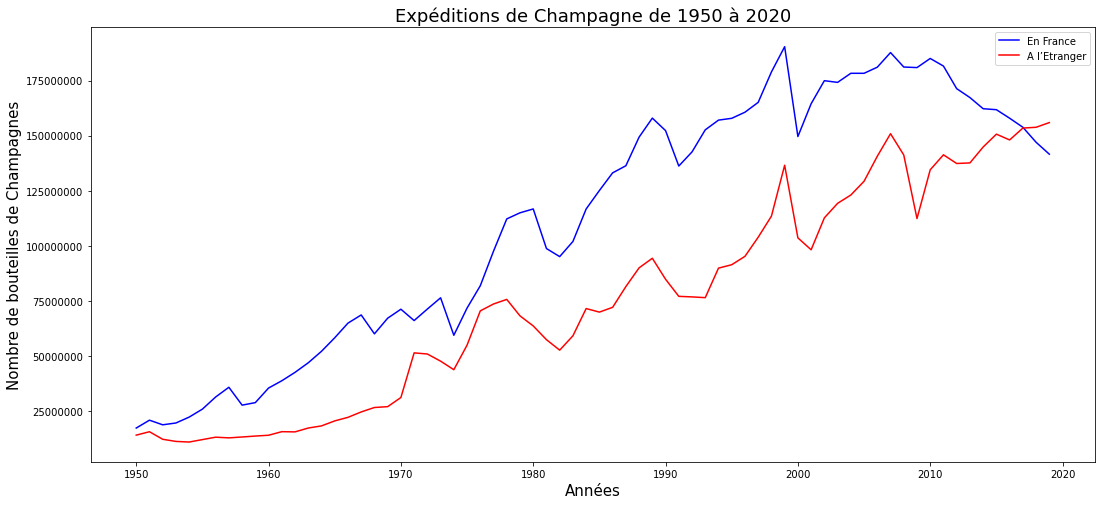

In [153]:
#On réalise un graphique à l'aide de pyplot
plt.figure(figsize = (18,8))

#France
plt.plot("Années", "En France", data=df_exp, color='blue')

#Etranger
plt.plot("Années", "A l’Etranger", data=df_exp, color='red')

#Mise en forme du graphique
plt.title("Expéditions de Champagne de 1950 à 2020", fontsize=18)
plt.xlabel("Années",fontsize=15)
plt.ylabel("Nombre de bouteilles de Champagnes", fontsize=15)
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.legend()
plt.show()

Ce graphique montre l'évolution des expéditions de bouteilles Champagne en France et à l'Etranger depuis 1950. On remarque que des années 1950 à la fin des années 2000 les expéditions de Champagne ont connu une forte croissance en France et à l'Etranger. De plus, les expéditions en France et à l'Etranger ont crû relativement à la même vitesse. 

Toutefois depuis la fin des années 2000 les expéditions de Champagne en France ont commencé à décroître alors qu'elles continuaient de croître à l'Etranger et au milieu des années 2010 le nombre d'expéditions de bouteilles à l'Etranger a dépassé le nombre d'expéditions de bouteilles en France, suggérant que le marché international devient de plus en plus porteur et que les consommateurs étrangers sont de plus en plus désireux de consommer du Champagne. 

Il convient toutefois de noter que la forte croissance des expéditions de Champagne à l'étranger cache de grandes disparités d'importation et de consommation entre les pays. 

## Une mondialisation partielle du Champagne

On va tout d'abord regarder la distribution de nos données sur les exportations de Champagne dans les différents pays du monde afin de voir si elles sont plutôt regroupées ce qui irait dans le sens d'une consommation relativement unformisée du Champagne dans le monde ou si, au contraire, il y a une grande amplitude ce qui supposerait une consommation de Champagne fortement différenciée entre les différents pays du monde. 

Nous choisissons de visualiser nos données à l'aide d'une "boîte à moustache". 

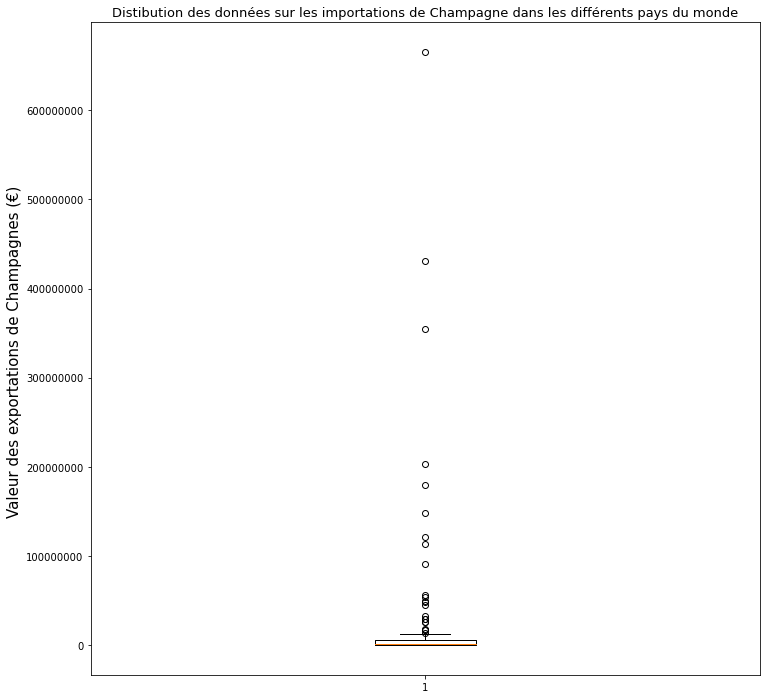

In [154]:
#On réalise un graphique à l'aide de pyplot
plt.figure(figsize =(12, 12)) 
plt.boxplot('Importations de Champagne (€)', data=df_final) 

#Mise en forme du graphique
plt.title("Distibution des données sur les importations de Champagne dans les différents pays du monde", fontsize=13)
plt.ylabel("Valeur des exportations de Champagnes (€) ", fontsize=15)
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.show() 

On remarque que, dans l'ensemble, les données sont resserrées vers les bas de la distribution avec toutefois un certain nombre de pays qui se démarquent des autres par la valeur très élevée de leurs importations de Champagne: on a donc beaucoup d'"outliers". Pour mieux se rendre compte de la distibution du gros de nos données on opère un zoom sur la boite. 

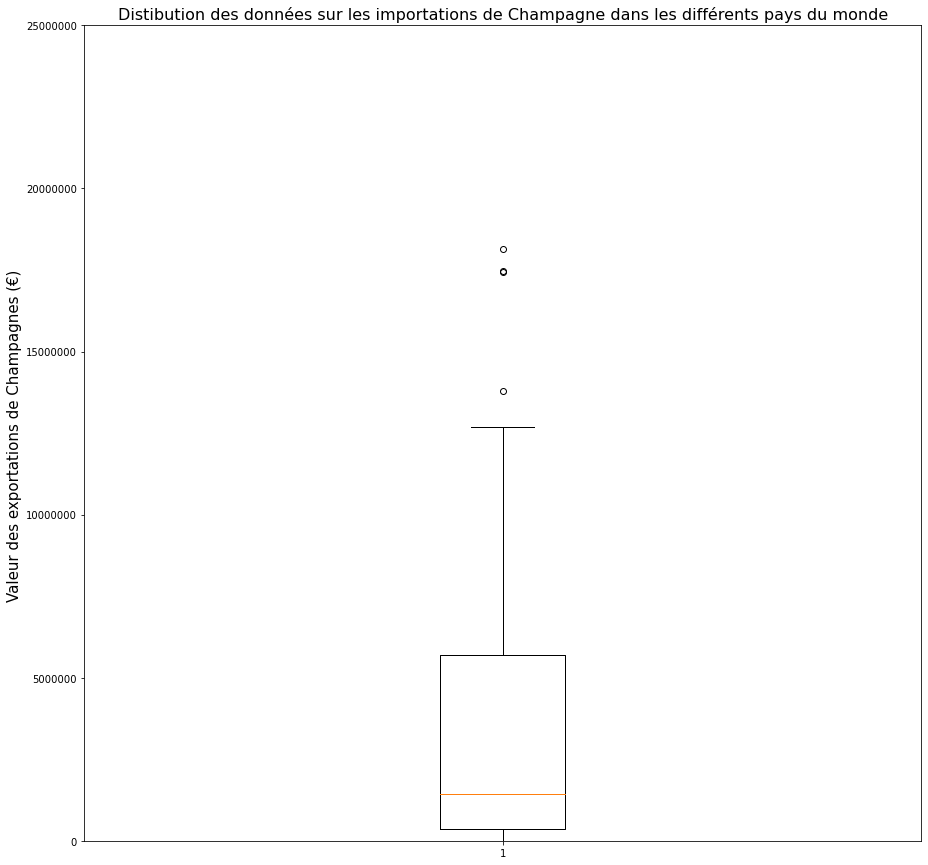

In [155]:
#On réalise un graphique à l'aide de pyplot
plt.figure(figsize =(15, 15)) 
plt.boxplot('Importations de Champagne (€)', data=df_final) 

#Mise en forme du graphique
plt.title("Distibution des données sur les importations de Champagne dans les différents pays du monde", fontsize=16)
plt.ylabel("Valeur des exportations de Champagnes (€) ", fontsize=15)
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))

#On opère le zoom
plt.ylim(0,25000000) 
plt.show() 

Ce dernier graphique nous permet de mieux nous rendre compte des habitudes de consommation du Champagne dans la majorité des pays du monde. On calcule désormais des statistiques descriptives qui vont faciliter l'interprétation de nos données.

In [156]:
médiane=df_final["Importations de Champagne (€)"].median()
premier_quartile=df_final["Importations de Champagne (€)"].quantile(0.25)
troisième_quartile=df_final["Importations de Champagne (€)"].quantile(0.75)
maximum=df_final["Importations de Champagne (€)"].max()
minimum=df_final["Importations de Champagne (€)"].min()
moyenne=df_final["Importations de Champagne (€)"].mean()


print("La médiane des importations de Champagne est de",médiane,"€")
print("Le premier quartile des importations de Champagne est de",premier_quartile,"€")
print("Le troisième quartile des importations de Champagne est de",troisième_quartile,"€")
print("La valeur maximale des importations de Champagne est de",maximum,"€")
print("La valeur minimale des importations de Champagne est de",minimum,"€")
print("La moyenne des importations de Champagne est de",moyenne,"€")


La médiane des importations de Champagne est de 1434914.0 €
Le premier quartile des importations de Champagne est de 351082.0 €
Le troisième quartile des importations de Champagne est de 5699075.5 €
La valeur maximale des importations de Champagne est de 665230321 €
La valeur minimale des importations de Champagne est de 2777 €
La moyenne des importations de Champagne est de 20688149.346938774 €


On remarque que dans la plupart des pays du monde les importations de Champagne sont relativement faibles. Pour 50% des pays les importations annuelles n'excèdent pas **1,5 millions d'euros** et pour 75 % des pays elles n'excèdent pas **6 millions d'euros**. 

Toutefois les importations sont relativement élevées voire très elevées dans un petit groupe de pays ce qui tire la moyenne des importations vers le haut: elle est de plus de **20 millions d'euros** alors que la médiane n'est que de 1,5 millions d'euros. La valeur maximale est autour de **650 millions d'euros**, soit plus de 400 fois la valeur médiane. 

Il apparait donc bien que le Champagne est un produit dont la mondialisation est inachevée: un petit groupe de pays consomme la très grande majorité du Champagne que la France produit et exporte. Afin d'identifier et de visualiser ce groupe de pays, nous avons choisi de réaliser une carte interactive.

## Les importations de champagne dans les différents pays du monde 

In [157]:
#Préalable à la réalisation de la carte
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent="http")

In [158]:
#On récupère les coordonnées géographiques des pays de notre base
#Attention, l'étape est un peu longue (70 secondes environ)

geocode = []

for i, nom_pays in enumerate(df_final['Pays']):
    if i%10==0:
        print(i)
    if type(nom_pays) == str :
        if nom_pays!='ÉTATS-UNIS':
            pays_title_case = nom_pays.title()

            location = locator.geocode(pays_title_case, timeout=10)
        else:
            location=locator.geocode('USA',timeout=10)

        if location is not None:
            geocode.append([location.latitude, location.longitude])
        else:
            geocode.append(np.nan)        
    else:
        geocode.append(np.nan)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [159]:
#On rajoute une variable pour les coordonnées géographiques dans notre base
df_final["geocode"] = geocode

On peut désormais créer une carte montrant la valeur des exportations de Champagne en euros par pays en 2019.

In [160]:
ratio_visuel_radius = 0.00000009
m = folium.Map(
    location=[48.83197250251829, 2.3493561831074894],
    zoom_start=2,
    tiles='Stamen Terrain'
)


for pays, valeur, geo in zip(
    df_final["Pays"],
    df_final["Importations de Champagne (€)"],
    df_final["geocode"]):
    
  if geo != None and type(geo) == list:
    radius_calcul = ratio_visuel_radius * valeur
    chaine_popup = f"{pays} : {valeur}€"

    folium.CircleMarker(
      radius=radius_calcul,   
      location=geo,
      popup=chaine_popup,
      color='#3349ff',
      fill=True,
      fill_color='#e0e3ff'
      ).add_to(m)

m

Les cercles sont propotionnels à la valeur en euros des exportations de Champagne dans un pays donné. On remarque sur la carte que les plus gros cercles correspondent aux pays développées: il y a d'abord les voisins européens de la France comme l'Angleterre et l'Allemagne, puis on retrouve des pays comme le Japon, les Etats-Unis, l'Australie et le Canada. 

On remarque que dans des petits territoires tels que les Emirats Arabes Unis ou Hong-Kong avec une forte présence de touristes ou d'expatriés les importations sont plus elevées que dans les pays voisins. Dans les pays dits en développement les importations de Champagne restent relativement basses. 

# II. Les déterminants de l'importation et de la consommation de Champagne dans le monde

La partie précédente a mis en évidence les disparités qui existent entre les pays du monde en ce qui concerne l'importation et la consommation de Champagne. Si le Champagne est bien un produit mondialisé, sa mondialisation reste partielle. Après avoir constaté les différences dans l'importation et la consommation de Champagne, on souhaite expliquer ces différences par le biais de modèles. Dans cette partie on va chercher à déterminer les variables qui influençent le plus la consommation de Champagne dans un pays donné. 

Cette partie va notamment nous permettre de cibler les variables les plus pertinentes à prendre en compte pour un producteur de Champagne souhaitant exporter à l'Etranger.   

## Etude de la corrélation de nos variables entre elles 

### Les déterminants commerciaux

Dans un premier temps, on étudie les corrélations entre notre variable dépendante, soit les importations de Champagne (en valeur) et les variables qui décrivent l'intégration et le positionnement des pays dans le commerce international. Avant de s'intéresser aux caractéristiques socio-économiques et culturelles des pays, on regarde les caractéristiques strictement "commerciales" des pays. 

Ce tableau de correlation se concentre donc sur les variables nous donnant des informations sur l'intégration du pays au commerce international avec la part des importations totales dans le PIB et les droits de douane, sur la taille du marché et sur la distance avec la France. 

In [161]:
#On sélectionne nos variables d'intérêt
df_correlation_1 = df_final[["Importations de Champagne (€)","Importations totales en % du PIB","Distance avec la France (km)","Taxes de Douane (%)", "Population totale"]]

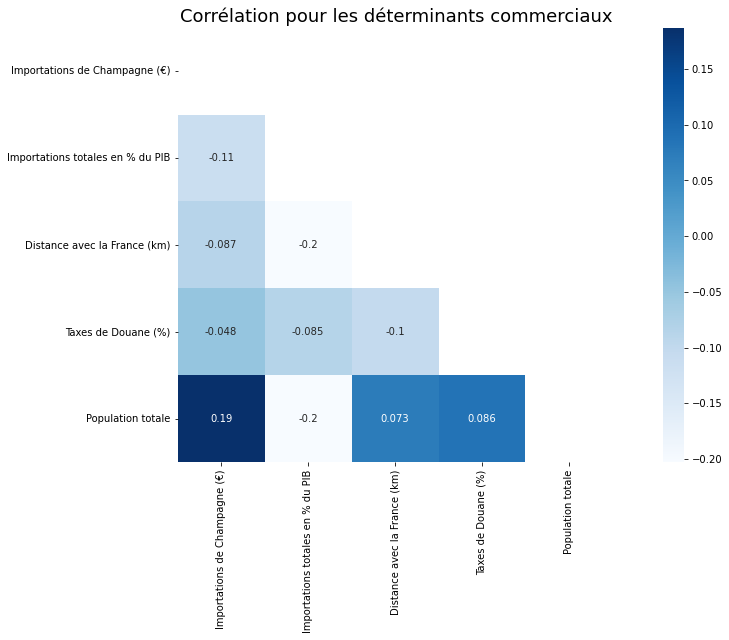

In [162]:
#On construit la matrice de corrélation
corr_matrice_1 = df_correlation_1.corr()
matrice = np.triu(corr_matrice_1)

#On réalise le tableau de corrélation
plt.figure(figsize = (18,8))
sns.heatmap(corr_matrice_1, annot = True,square = True, mask = matrice, cmap='Blues')
plt.title("Corrélation pour les déterminants commerciaux", fontsize = 18, loc="right")
plt.show()

On remarque que les deux variables les plus correlées sont les importations de Champagne en valeur et la population totale (corrélation positive). Sans surprise, plus le pays est peuplé, plus il a de consommateurs potentiels de Champagne et donc plus les importations de Champagne sont importantes.

Les importations de Champagne sont négativement correlées aux taxes de douane sur les vins pétillants et à la distance avec la France, ce que l'on supposait, mais cette corrélation reste relativement faible. 

### Les déterminants socio-économiques et culturels
Dans un second temps, on étudie les corrélations entre notre variable dépendante, soit les exportations de Champagne et les variables qui nous donnent des informations sur les caractéristiques socio-économiques et culturelles des pays. On regarde également si les variables qui nous informent sur la pertinance d'exporter du champagne dans tel ou tel pays sont correlées entee elles.

In [163]:
#On sélectionne nos variables d'intérêt
df_correlation_2 = df_final[["Importations de Champagne (€)","Importations de vin ($)","Part de Vin dans la consommation d'alcool (%)", "Nombre annuel de touristes", "Nombre d'expatriés français", "PIB par habitant en PPA","Pourcentage De Musulmans (%)", "Taux de pauvreté (%)","Taux d'inscription dans le supérieur (%)","Global Peace Index"]]

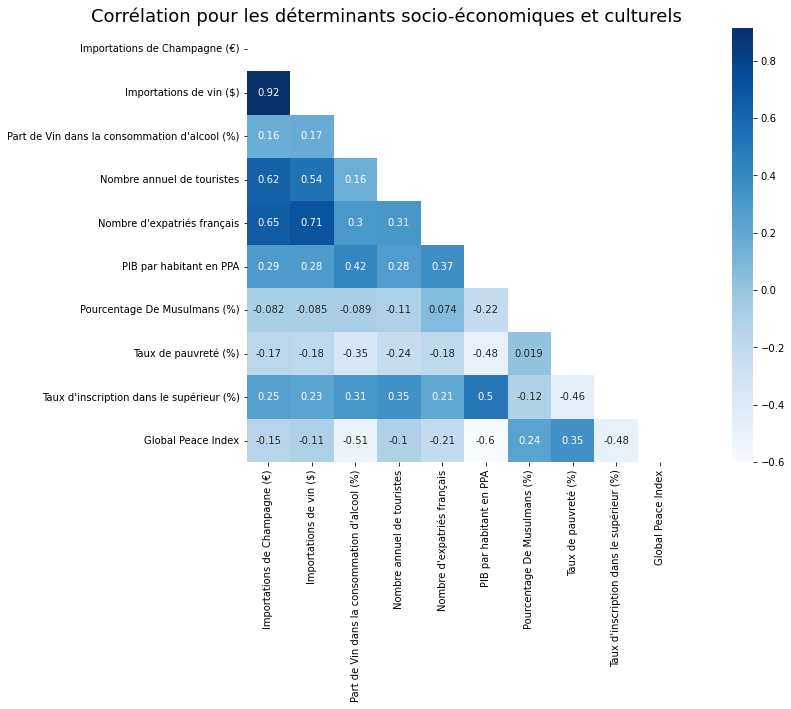

In [164]:
#On construit la matrice de correlation
corr_matrice_2 = df_correlation_2.corr()
matrice = np.triu(corr_matrice_2)

#On réalise le tableau de correlation
plt.figure(figsize = (18,8))
sns.heatmap(corr_matrice_2, annot = True,square = True, mask = matrice, cmap='Blues')
plt.title("Corrélation pour les déterminants socio-économiques et culturels", fontsize = 18, loc="right")
plt.show()

On remarque que nos variables sont dans l'ensemble assez fortement corellées entre elles, les coefficients étant importants en valeur absolue.

Tout d'abord, il apparait que les importations de Champagne en valeur sont fortement correlées positivement avec les importations de vin en valeur (coefficient de **0.92**). On en déduit que les importations de vin sont un très bon indicateur pour la prédiction des importations de Champagne. 

Les importations de Champagne sont aussi fortement correlées positivement avec le nombre annuel de touristes (**0.62**) et le nombre d'expatriés français (**0.65**). On remarque que la corrélation est du même ordre ce qui semble indiquer que touristes et expatriés jouent un rôle assez similaire dans la consommation du Champagne dans un pays donné. Toutefois pour vérifier cette interprétation il nous faut conduire des régressions. 

Les importations de Champagne sont correlées positvement au PIB par habitant (**0.29**) et au taux d'inscription dans le supérieur (**0.25**). Ici encore la corrélation est du même ordre ce qui laisse supposer que niveau de vie et niveau d'éducation ont un rôle proche dans l'explication de la consommation de Champagne dans un pays. Encore une fois on doit conduire des régessions pour démêler le pouvoir explicatif de nos variables.

Les importations de Champagne sont correlées négativement au Global peace Index (**-0.15**) et au taux de pauvreté (**-0.17**). Sans surprise, la pauvreté et l'instabilité politique pèsent négativement sur la consommation de Champagne. 

Le pourcentage de musulmans dans un pays est assez faiblement correlé négativement aux importations de Champagne (**0.082**), ce qui peut nous laisser penser que le facteur religieux n'est pas déterminant pour les importations de Champagne.

On peut ensuite regarder brièvement les corrélations des variables entre elles: sans grande surprise le PIB par habitant et le taux d'inscription dans le supérieur sont positivement corrélés aux importations de vin, à la part de vin dans la consommation d'alcool, au nombre annuel de touristes et au nombre d'expatriés français. A l'inverse, la variable Global Peace Index est négativement correlée à toutes ces variables mais elle positivement corrélée au taux de pauvreté.

## Régressions simples

On réalise tout d'abord des régressions simples qui vont nous permettre de tester le pouvoir explicatif de nos variables et leur significativité.

### Régression des importations de Champagne en valeur sur le PIB par habitant ($PPA)

In [165]:
X=df_final["PIB par habitant en PPA"]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_pib = model.fit()
print(results_pib.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Importations de Champagne (€)   R-squared:                       0.085
Model:                                       OLS   Adj. R-squared:                  0.078
Method:                            Least Squares   F-statistic:                     12.66
Date:                           Thu, 06 Jan 2022   Prob (F-statistic):           0.000516
Time:                                   16:03:16   Log-Likelihood:                -2697.4
No. Observations:                            138   AIC:                             5399.
Df Residuals:                                136   BIC:                             5405.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------

/Users/louisebonhomme/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Nous obtenons un coefficient positif et significatif au seuil de 1%: toutes choses égales par ailleurs, quand le PIB par habitant augmente de 1$ les importations de Champagne augmentent en moyenne de 954€ environ. On peut penser ici que notre coefficient est biaisé positivement et qu'on surestime le rôle du PIB. On serait face à un biais de variable omise: il faudrait alors ajouter des variables qui sont correlées au PIB par habitant et aux importations de Champagne pour corriger ce biais. 

### Régression des importations de Champagne en valeur sur la population totale

In [166]:
X=df_final["Population totale"]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_pop = model.fit()
print(results_pop.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Importations de Champagne (€)   R-squared:                       0.035
Model:                                       OLS   Adj. R-squared:                  0.028
Method:                            Least Squares   F-statistic:                     5.233
Date:                           Thu, 06 Jan 2022   Prob (F-statistic):             0.0236
Time:                                   16:03:16   Log-Likelihood:                -2853.9
No. Observations:                            146   AIC:                             5712.
Df Residuals:                                144   BIC:                             5718.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------

/Users/louisebonhomme/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Nous obtenons un coefficient positif et significatif au seuil de 5%: toutes choses égales par ailleurs, quand la population augmente de une personne, on prévoit que les importations de champagnes augmentent en moyenne de 0,12€ environ. 

### Régression des importations de Champagne en valeur sur le nombre annuel de touristes

In [167]:
X=df_final["Nombre annuel de touristes"]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_touristes = model.fit()
print(results_touristes.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Importations de Champagne (€)   R-squared:                       0.390
Model:                                       OLS   Adj. R-squared:                  0.385
Method:                            Least Squares   F-statistic:                     86.29
Date:                           Thu, 06 Jan 2022   Prob (F-statistic):           3.53e-16
Time:                                   16:03:16   Log-Likelihood:                -2650.6
No. Observations:                            137   AIC:                             5305.
Df Residuals:                                135   BIC:                             5311.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----

/Users/louisebonhomme/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Nous obtenons un coefficient positif et significatif au seuil de 1%: toutes choses égales par ailleurs on prévoit que l'arrivée d'un touriste de plus dans le pays par an augmente en moyenne les importations de champagnes de 2€ environ.

### Régression des importations de Champagne en valeur sur le taux de pauvreté

In [168]:
X=df_final["Taux de pauvreté (%)"]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_pauvrete = model.fit()
print(results_pauvrete.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Importations de Champagne (€)   R-squared:                       0.027
Model:                                       OLS   Adj. R-squared:                  0.018
Method:                            Least Squares   F-statistic:                     3.038
Date:                           Thu, 06 Jan 2022   Prob (F-statistic):             0.0842
Time:                                   16:03:16   Log-Likelihood:                -2165.1
No. Observations:                            110   AIC:                             4334.
Df Residuals:                                108   BIC:                             4340.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------

/Users/louisebonhomme/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Nous obtenons un coefficient négatif et significatif au seuil de 10%: toutes choses égales par ailleurs quand le taux de pauvreté augmente de 1% on prévoit que les importations de Champagne baissent de 900 000€ environ. Ce coefficient semble beaucoup trop élevé en valeur absolue. On est à nouveau confronté à un bais de variables omises car il existe de nombreuses variables qui sont corrélées à la fois au taux de pauvreté et aux importations de Champagne. On peut espérer qu'en conduisant une régression multiple ce biais disparaisse ou s'atténue. 

#### *On choisit de ne plus afficher les régressions pour les variables suivantes afin de faciliter la lecture du fichier.*

### Régression des importations de Champagne en valeur sur l'éducation

In [169]:
X=df_final["Taux d'inscription dans le supérieur (%)"]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_education= model.fit()
#print(results_education.summary())

/Users/louisebonhomme/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


On obtient un coefficient significatif et positif.

### Régression des importations de Champagne en valeur sur les importations de vin

In [170]:
X=df_final["Importations de vin ($)"]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_vin= model.fit()
#print(results_vin.summary())

On obtient un coefficient significatif et positif. 

### Régression des importations de Champagne en valeur sur le nombre d'expatriés

In [171]:
X=df_final["Nombre d'expatriés français"]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_expat = model.fit()
#print(results_expat.summary())

On obtient un coefficient significatif et positif.

#### *Dans les régressions suivantes aucun des coefficients n'est significatif*

### Régression des importations de Champagne sur part de la consommation d'alcool

In [172]:
X=df_final["Part de Vin dans la consommation d'alcool (%)"]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_conso_vin = model.fit()
#print(results_conso_vin.summary())

### Régression des importations de Champagne sur part des musulmans

In [173]:
X=df_final["Pourcentage De Musulmans (%)"]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_musulmans = model.fit()
#print(results_musulmans.summary())

### Régression des importations de Champagne sur le Global Peace Index

In [174]:
X=df_final["Global Peace Index"]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_gpi = model.fit()
#print(results_gpi.summary())

### Régression des importations de Champagne sur la distance avec la France

In [175]:
X=df_final["Distance avec la France (km)"]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_dist = model.fit()
#print(results_dist.summary())

### Régression des importations de Champagne sur les taxes de douane

In [176]:
X=df_final["Taxes de Douane (%)"]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_taxes = model.fit()
#print(results_taxes.summary())

### Régression des importations de Champagne sur les importations totales en % du PIB

In [177]:
X=df_final["Importations totales en % du PIB"]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_imp_tot = model.fit()
#print(results_imp_tot.summary())

En conduisant les régressions simple des importations de Champagne sur les taxes de douane, la distance avec la France ou encore les importations totales, on se rend compte que les coefficients ne sont pas significatifs. 

On peut supposer que ces déterminants du commerce internationale rentrent peu en compte dans les importations du Champagne, un produit de luxe consommé par une minorité de la population. En effet, on peut faire l'hypothèse que même si les taxes de douane sont élevées et l'acheminement depuis la France long et complexe, il existe dans les pays une demande plancher pour le Champagne qui est le fait d'une partie des classes supérieures désireuses de consommer à l'occasion d'évènements festifs ce produit distinctif qu'est le Champagne.

L'absence de significativité du coefficient dans la régression sur les taxes de douane reste toutefois surprenante. On peut alors suspecter des failles dans nos données: les montants des taxes prélevées sur le vin pétillant que nous avons récupérés et utilisés ne recoupent peut-être pas exactement les taxes effectivement appliquées sur les importations de Champagne en provenance de la France. 

Néanmoins, ces régressions simples nous confirment ce que les tableaux de corrélations laissaient entrevoir : ce sont les variables socio-économiques et culturelles qui déterminent les importations du Champagne dans un pays donné. Mais pour avoir une idée plus juste du pouvoir explicatif de nos variables et pour tenter de remédier aux biais de variable omise nous devons conduire des régressions multiples. 

## Régressions multiples

Dans un premier temps, nous conduisons une régression multiple avec toutes nos variables. 

### Première régression

In [178]:
X=df_final[["Nombre annuel de touristes","Importations de vin ($)", "Part de Vin dans la consommation d'alcool (%)","Importations totales en % du PIB","Population totale","Nombre d'expatriés français", "PIB par habitant en PPA", "Taux de pauvreté (%)", "Taux d'inscription dans le supérieur (%)", "Global Peace Index", "Pourcentage De Musulmans (%)","Distance avec la France (km)","Taxes de Douane (%)"]]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_reg_multiple_1 = model.fit()
print(results_reg_multiple_1.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Importations de Champagne (€)   R-squared:                       0.668
Model:                                       OLS   Adj. R-squared:                  0.381
Method:                            Least Squares   F-statistic:                     2.324
Date:                           Thu, 06 Jan 2022   Prob (F-statistic):             0.0604
Time:                                   16:03:16   Log-Likelihood:                -515.65
No. Observations:                             29   AIC:                             1059.
Df Residuals:                                 15   BIC:                             1078.
Df Model:                                     13                                         
Covariance Type:                       nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.02

On se rend compte que dans cette régression, on a seulement un coefficient significatif au seuil de 10% (coefficient sur les importations de vin). On choisit alors de conduire une autre régression en ne gardant que les variables qui étaient significatives en régression simple. 

In [179]:
X=df_final[["Importations de vin ($)","Nombre annuel de touristes", "PIB par habitant en PPA", "Taux d'inscription dans le supérieur (%)", "Nombre d'expatriés français", "Taux de pauvreté (%)"]]
y= df_final["Importations de Champagne (€)"]
X=sm.add_constant(X)
model = sm.OLS(y,X,missing="drop")
results_reg_multiple_2 = model.fit()
print(results_reg_multiple_2.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Importations de Champagne (€)   R-squared:                       0.731
Model:                                       OLS   Adj. R-squared:                  0.700
Method:                            Least Squares   F-statistic:                     23.51
Date:                           Thu, 06 Jan 2022   Prob (F-statistic):           3.20e-13
Time:                                   16:03:16   Log-Likelihood:                -1118.9
No. Observations:                             59   AIC:                             2252.
Df Residuals:                                 52   BIC:                             2266.
Df Model:                                      6                                         
Covariance Type:                       nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025    

/Users/louisebonhomme/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Dans cette régression nous obtenons deux coefficients significatifs.

- Le coefficient sur les **importations de vin** est significatif au seuil de 1%: toutes choses par ailleurs quand les importations de vin augmentent de 1$ les importations de Champagne augmentent de **0.08 euros** en moyenne.
- Le coefficient sur le **nombre annuel de touristes** est significatif au seuil de 5%: toutes choses égales par ailleurs quand il y a un touriste supplémentaire qui vient dans le pays les importations de Champagne augmentent de **0.5 euros** en moyenne.

On obtient un coefficient de détermination (R2) de 73.3% ce qui nous indique que le variabilité de nos données est bien expliquée par notre modèle.

Il semble donc que le tourisme et les importations de vin soient les meilleurs déterminants de l'importation et de la consommation de Champagne. 

# III. Les opportunités dans les pays en développement: études de cas d'un producteur 

Nous adoptons maintenant le point de vue d'un producteur de Champagne qui veut développer ses exportations dans des pays en développement et recherche un pays dans lequel il y aurait un marché porteur pour le Champgane. 

- Premièrement, nous choisissons de séparer les **pays en développement** des autres pays à partir d'un critère simple: le **PIB par habitant** en parité de pouvoir d'achat. Nous décidons d'éliminier les pays plus pauvres qui ne sont pas susceptibles de convenir pour l'exportation du Champagne et les pays les plus riches dans lesquels les exportateurs de Champagne sont déjà bien implantés.

- De plus, ouvrir son marché à un pays inconnu étant risqué, nous choisissons de supprimer les pays au sujet desquels nous ne sommes pas complètement informés (nous nous concentrons sur les pays pour lesquels nous avons des valeurs pour toutes les variables de notre base). 

In [180]:
print("1er quartile du PIB par habitant en PPA:" ,df_final['PIB par habitant en PPA'].quantile(0.25),"$")
print("3ème quartile du PIB par habitant en PPA:",df_final['PIB par habitant en PPA'].quantile(0.75),"$")

1er quartile du PIB par habitant en PPA: 7302.25660608016 $
3ème quartile du PIB par habitant en PPA: 38214.91953233103 $


Nous choisissons de sélectionner les pays entre les premier et troisième quartiles du PIB par habitant en PPA: c'est un intervalle arbitraire mais il semble bien capter les pays dits en développement. 

In [181]:
#Sélection des pays dont le PIB par habitant est entre 7302$ et 38214$ et création d'une nouvelle table découlant de df_final
df_pays_developpement=df_final[df_final['PIB par habitant en PPA'].apply(lambda x: x>df_final['PIB par habitant en PPA'].quantile(0.25))]
df_pays_developpement=df_pays_developpement[df_pays_developpement['PIB par habitant en PPA'].apply(lambda x: x<df_final['PIB par habitant en PPA'].quantile(0.75))]

#On supprime tous les NaN puisque nous voulons être en information complète pour chaque pays
df_pays_developpement.dropna(inplace=True)

df_pays_developpement.reset_index(drop=True,inplace=True)

df_pays_developpement

,Code Pays,Pays,Importations de Champagne (€),Importations de vin ($),Part de Vin dans la consommation d'alcool (%),Importations totales en % du PIB,Nombre annuel de touristes,Population totale,Nombre d'expatriés français,PIB par habitant en PPA,Taux de pauvreté (%),Taux d'inscription dans le supérieur (%),Global Peace Index,Pourcentage De Musulmans (%),Distance avec la France (km),Taxes de Douane (%),geocode
0,ALB,ALBANIE,693673,12416000.0,26.5,44.106203,5546750.0,2861573.6,204.0,13328.275340,14.3,57.662016,1.8876,0.7,1603.534,15.000000,"[41.000028, 19.9999619]"
1,DZA,ALGÉRIE,372364,7094000.0,24.4,31.383153,2379500.0,42214616.8,40173.0,11720.187773,5.5,49.351982,2.2106,98.0,1340.390,30.000000,"[28.0000272, 2.9999825]"
2,BRA,BRÉSIL,10566914,421768000.0,3.4,13.588598,6527500.0,209415025.8,16916.0,14803.868097,8.7,52.674712,2.1914,0.1,9408.406,20.000000,"[-10.3333333, -53.2]"
3,CHL,CHILI,2148812,12783000.0,33.1,27.743869,6591750.0,18695383.4,13617.0,24738.243108,8.6,89.912498,1.6284,0.1,11663.390,6.000000,"[-31.7613365, -71.3187697]"
4,HRV,CROATIE,3761527,31192000.0,39.0,48.936938,58628500.0,4099835.2,1071.0,28289.785056,19.5,67.443480,1.6570,0.5,1081.762,16.545455,"[45.5643442, 17.0118954]"
5,EST,ESTONIE,6965425,74995000.0,7.4,71.522091,6055750.0,1322621.2,340.0,35502.619804,21.1,71.258448,1.7244,0.1,1859.091,0.000000,"[58.71971295, 24.507544106789936]"
6,GTM,GUATEMALA,281935,12958000.0,2.1,27.395237,2248000.0,16344883.4,1008.0,8615.787919,59.3,22.142200,2.2444,0.1,9001.048,20.000000,"[15.687100699999998, -90.12265453178017]"
7,HUN,HONGRIE,3426149,23890000.0,32.2,78.802445,56729000.0,9779691.4,2556.0,31305.417253,14.5,49.822605,1.5190,0.1,1247.240,62.900000,"[47.1817585, 19.5060937]"
8,KAZ,KAZAKHSTAN,965500,35880000.0,6.5,26.642249,7878500.0,18275279.2,358.0,25810.017049,2.5,56.635650,1.9768,0.2,5561.785,12.500000,"[47.2286086, 65.2093197]"
9,LVA,LETTONIE,4578692,138564000.0,11.1,60.670177,7660000.0,1928865.8,312.0,30131.912313,21.8,89.137814,1.6902,0.1,1704.598,8.750000,"[56.8406494, 24.7537645]"


Finalement, cette sélection aboutit à **18** pays en développement avec information complète.  

## Système de notation

Maintenant, il nous faut trouver un système de notation permettant d'évaluer l'opportunité d'exportation dans un de ces pays. Cette étape repose sur les conclusions de la partie précédente sur l'analyse des déterminants. En effet, les régressions faites précédemment nous ont permis d'identifier les variables qui ont le plus de poids dans l'explication des importations de Champagne dans un pays donné.


Notre système de notation va donc reposer sur une moyenne pondérée de notes que nous avons attribuées à tous les pays sélectionnés à l'étape précédente. Tous les pays se voient attribués une note par variable qui est définie de la façon suivante: $$ \frac{x}{mean(x)} $$. 

Pour chaque variable, nous comparons sa valeur pour un pays donné à sa moyenne sur l'ensemble des pays en développement selectionnés. Ce quotient relativement facile à interpréter va permettre de situer le pays par rapport aux autres: par exemple pour une variable donnée si le quotient est inférieur à 1, alors exporter du Champagne dans ce pays semble relativement moins intéressant du point de vue de cette variable.

Par exemple, si nous nous intéressons à la part de vin dans la consommation d'alcool:
- la moyenne pour les pays en développement selectionnés s'élève à environ 16%
- si nous regardons l'Ukraine, sa part de consommation de vin est de 5,4% donc sa part consommation de vin est égale 33% de la consommation moyenne. Sa note serait 0,33.
- si nous regardons maintenant l'Argentine, sa part de consommation de vin est de 40,2% soit 251% de la consommation moyenne. Sa note serait 2,51.

Du seul point de vue de la consommation de vin, l'Argentine semble représenter une meilleure opportunité que l'Ukraine pour un exportateur de Champagne.

### Visualisation de la distance à la moyenne

Pour avoir une idée de la manière dont les pays se positionnent les uns par rapport aux autres du point de vue des différents déterminants des importations de Champagne, nous proposons de faire apparaître sur un même graphique la moyenne d'une variable d'intérêt donnée et la valeur prise par cette variable pour tous les pays. 

Pour ne pas nuire à la clareté du script en affichant le graphique pour toutes nos variables, nous avons choisi d'ajouter un "widget" permettant de sélectionner la variable que l'on souhaite visualiser. Pour cela il suffit de dérouler le bandeau et de selectionner la variable souhaitée puis de faire tourner la cellule de code qui suit le bandeau "widget" (il n'est pas nécessaire de refaire touner le code "widget" à chaque fois, sélectionner la variable suffit pour afficher le graphique).

In [182]:
w=widgets.Dropdown(
    options=df_pays_developpement.columns[3:16],
    value='Importations de vin ($)',
    description='Variable:',
    disabled=False,
)
display(w)

Dropdown(description='Variable:', options=('Importations de vin ($)', "Part de Vin dans la consommation d'alco…

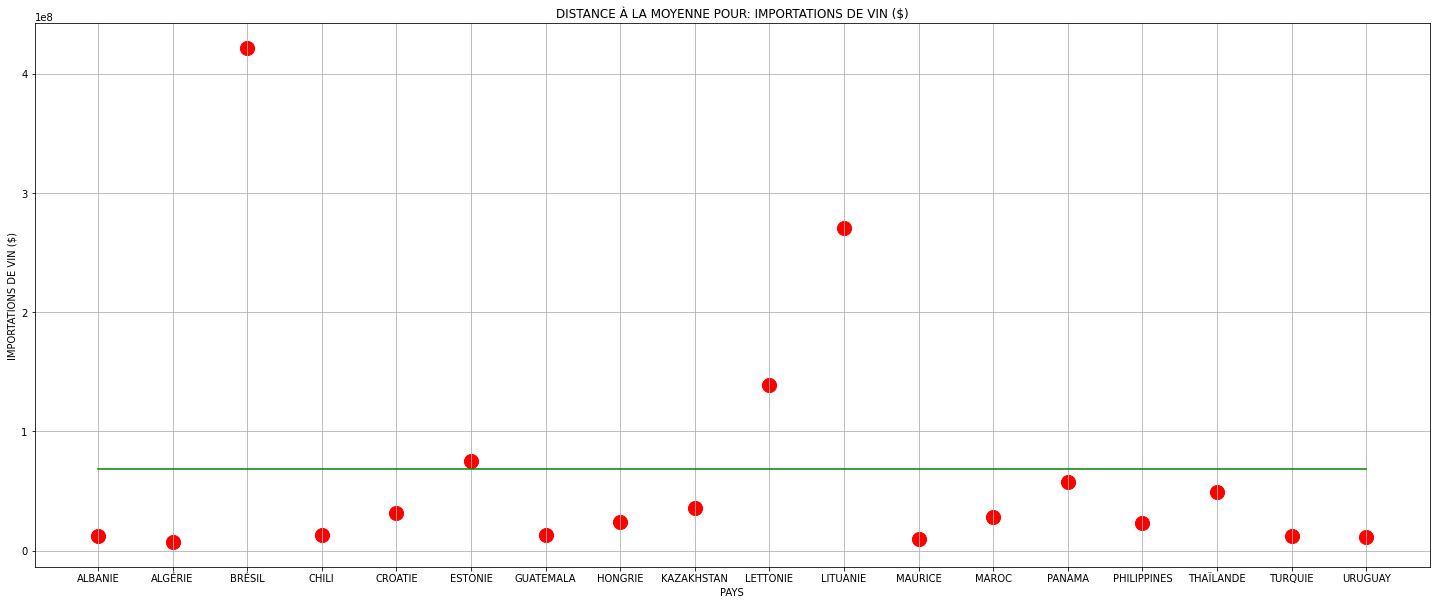

In [183]:
plt.figure(figsize=(25,10))
colonne=w.value
plt.scatter(df_pays_developpement['Pays'],df_pays_developpement[colonne],s=200, color='red')
plt.plot(df_pays_developpement['Pays'],[df_pays_developpement[colonne].mean() for i in range(df_pays_developpement.shape[0])],color='green')
plt.grid()
plt.xlabel('PAYS')
plt.ylabel(colonne.upper())
plt.title('Distance à la moyenne pour: '.upper()+colonne.upper())
plt.show()

In [184]:
#Création des notes et remplacement de la valeur des variables par ces notes
for i in range(3,16):
    moyenne=df_pays_developpement.iloc[:,i].mean()
    df_pays_developpement.iloc[:,i]=df_pays_developpement.iloc[:,i].apply(lambda x: x/moyenne)
df_pays_developpement.head()

,Code Pays,Pays,Importations de Champagne (€),Importations de vin ($),Part de Vin dans la consommation d'alcool (%),Importations totales en % du PIB,Nombre annuel de touristes,Population totale,Nombre d'expatriés français,PIB par habitant en PPA,Taux de pauvreté (%),Taux d'inscription dans le supérieur (%),Global Peace Index,Pourcentage De Musulmans (%),Distance avec la France (km),Taxes de Douane (%),geocode
0,ALB,ALBANIE,693673,0.181238,1.553240,1.012594,0.368544,0.081639,0.020839,0.605161,0.906019,0.956953,0.961002,0.059603,0.290037,0.593804,"[41.000028, 19.9999619]"
1,DZA,ALGÉRIE,372364,0.103552,1.430153,0.720497,0.158102,1.204365,4.103752,0.532147,0.348469,0.819040,1.125445,8.344371,0.242441,1.187608,"[28.0000272, 2.9999825]"
2,BRA,BRÉSIL,10566914,6.156613,0.199284,0.311968,0.433708,5.974522,1.728003,0.672160,0.551214,0.874184,1.115671,0.008515,1.701734,0.791739,"[-10.3333333, -53.2]"
3,CHL,CHILI,2148812,0.186595,1.940085,0.636946,0.437977,0.533371,1.391004,1.123223,0.544879,1.492178,0.829040,0.008515,2.109601,0.237522,"[-31.7613365, -71.3187697]"
4,HRV,CROATIE,3761527,0.455314,2.285900,1.123499,3.895466,0.116967,0.109405,1.284479,1.235480,1.119285,0.843600,0.042573,0.195662,0.654984,"[45.5643442, 17.0118954]"


## Notation finale

### Première proposition

On utilise les résultats obtenus dans la partie précédente (partie II) qui nous ont permis d'identifier les déterminants les plus pertinents des importations de Champagne. On se base sur les régressions simples et on choisit de ne conserver que les variables dont les coefficients étaient significatifs pour le calcul de notre note finale moyenne attribuée à chaque pays. 

Ces variables sont les suivantes: 
- le PIB/habitant en PPA 
- la population totale
- le nombre de touristes annuel
- le nombre d'expatriés
- le taux de pauvreté
- les importations de vin 
- l'éducation (études supérieures)

Après avoit selectionné nos variables, il nous faut ajouter une pondération pour que notre note moyenne ait plus de sens. 

- Nous considérons que le coefficient de détermination des régressions simples est un bon indicateur du pouvoir prédictif de nos différentes variables. Cette stratégie est contestable mais elle nous semble toutefois judicieuse pour comparer le pouvoir prédictif de chaque variable. 
- Nous multiplions ce coefficient de détermination par la signe de la corrélation entre les importations de Champagne et la variable.

La note finale pour un pays i est donc définie comme: 
$$ N_i = \frac{1}{\sum_{j=1}^{k} (R^2_j)} * \sum_{j=1}^{k} (sign_j * R_j^2 n_{i,j}) * 100$$

$k$=nombre de variables,

$n_{i,j}$=note pour la variable j pour le pays i, 

$sign_j$=signe de la corrélation entre les importations de Champagne et la variable j.

In [185]:
#On construit la liste des coefficients de détermination 
#On remplace par 0 la valeur des coefficients pour les variables qu'on ne va pas utiliser
coefficients=[results_vin.rsquared,0,0,results_touristes.rsquared,results_pop.rsquared,results_expat.rsquared,results_pib.rsquared,-results_pauvrete.rsquared,results_education.rsquared,0,0,0,0]
print('Coefficients:' ,coefficients)
somme_coef=np.sum(np.abs(coefficients))

#On applique la formule pour trouver les notes
df_pays_developpement["Note_1"] = df_pays_developpement.iloc[:,3:16].dot(coefficients)/somme_coef*100

#Classement
df_pays_developpement[['Code Pays','Pays','Note_1']].sort_values(by='Note_1',ascending=False)

Coefficients: [0.8392702143266801, 0, 0, 0.389953408304484, 0.03506695425604078, 0.4214925904697878, 0.08513045590907897, -0.027360617519231467, 0.06094215942939374, 0, 0, 0, 0]


,Code Pays,Pays,Note_1
2,BRA,BRÉSIL,342.587929
10,LTU,LITUANIE,197.185614
12,MAR,MAROC,164.605433
15,THA,THAÏLANDE,123.460546
4,HRV,CROATIE,112.690141
9,LVA,LETTONIE,111.886104
16,TUR,TURQUIE,110.828942
7,HUN,HONGRIE,109.110742
1,DZA,ALGÉRIE,107.904432
5,EST,ESTONIE,68.004285


Dans la mesure où pour trouver notre note finale pour chaque pays nous faisons une moyenne pondérée des distances à la moyenne qui ont des unités et des échelles différentes, nous obtenons des notes qui ne s'échelonnent pas sur un intervalle fixé. Comme nous sommes intéressés uniquement par le classement, ce système de notation convient. 

D'après le tableau la meilleure opportunité pour un producteur de Champagne qui cherche un nouveau marché dans un pays développement pour exporter son Champagne se trouve au **Brésil**. Suivent la **Lituanie** et le **Maroc**.

### Deuxième proposition 

En faisant ce système de notation, nous mettons de côté certaines variables qui nous semblaient, a priori, pertinentes comme les taxes de douane sur les vins pétillants, la distance avec la France, la part de musulmans ou encore la part de vin dans la consommation d'alcool. 

Nous avons un doute sur la pertinence de la variable d'importations totales en pourcentage du PIB, notamment à cause du signe et de la valeur de son coefficient de corrélation avec les importations de Champagne. Nous préférons donc laisser cette variable de côté et ne pas l'inclure dans la note finale.

Nous décidons de regarder si l'intégration de toutes les variables (sauf les importations totales) change le pays dans lequel le producteur voit la meilleure opportunité pour exporter. 

Nous ne changeons pas la formule de la note finale définie comme: 
$$ N_i = \frac{1}{\sum_{j=1}^{k} (R^2_j)} * \sum_{j=1}^{k} (sign_j * R_j^2 n_{i,j}) * 100$$

$k$=nombre de variables,

$n_{i,j}$=note pour la variable j pour le pays i, 

$sign_j$=signe de la corrélation entre les importations de Champagne et la variable.

In [186]:
#On construit la liste des coefficients de détermination 
#On remplace par 0 la valeur du coefficient des importations totales en % du PIB
coefficients=[results_vin.rsquared,results_conso_vin.rsquared,0,results_touristes.rsquared,results_pop.rsquared,results_expat.rsquared,results_pib.rsquared,-results_pauvrete.rsquared,results_education.rsquared,-results_gpi.rsquared,-1*results_musulmans.rsquared,-results_dist.rsquared,-results_taxes.rsquared]
print('Coefficients:' ,coefficients)
somme_coef=np.sum(np.abs(coefficients))
df_pays_developpement["Note_2"] = df_pays_developpement.iloc[:,3:16].dot(coefficients)/somme_coef*100

#Classement
df_pays_developpement[['Code Pays','Pays','Note_2']].sort_values(by='Note_2',ascending=False)

Coefficients: [0.8392702143266801, 0.02661196157219614, 0, 0.389953408304484, 0.03506695425604078, 0.4214925904697878, 0.08513045590907897, -0.027360617519231467, 0.06094215942939374, -0.02136921004042336, -0.006657829764212919, -0.0075797668100784366, -0.0023062044886008604]


,Code Pays,Pays,Note_2
2,BRA,BRÉSIL,329.365061
10,LTU,LITUANIE,189.844845
12,MAR,MAROC,157.874036
15,THA,THAÏLANDE,117.291662
4,HRV,CROATIE,110.965112
9,LVA,LETTONIE,107.911483
7,HUN,HONGRIE,106.812466
16,TUR,TURQUIE,105.724942
1,DZA,ALGÉRIE,101.887619
5,EST,ESTONIE,65.212692


Finalement, avec cette nouvelle notation, le classement des pays ne change pas malgré des notes qui baissent en moyenne. Ce résultat confirme que nous avions bien identifié les variables pertinentes dans notre première proposition, à savoir: la population totale, le PIB par habitant en PPA, les importations de vin, le taux de pauvreté, la population totale, le nombre de touristes, les expatriés français et l'éducation. 

Nous choisissons de n'inclure que les déterminants les plus pertinents de l'importation et la consommation de Champagne et gardons donc le système de notation de la première proposition. 

## Cartographie des opportunités pour l'exportation de Champagne dans les pays en développement

Nous construisons une carte qui va nous permettre de visualiser les opportunités pour les exportateurs de Champagne. 

In [187]:
# Séparation en 4 table suivant les notes finales: [200,], [100,200], [50,100], [0,50] 
df_note_1=df_pays_developpement[df_pays_developpement['Note_1']>200]
df_note_2=df_pays_developpement[df_pays_developpement['Note_1']>100]
df_note_2=df_note_2[df_note_2['Note_1']<200]
df_note_3=df_pays_developpement[df_pays_developpement['Note_1']>50]
df_note_3=df_note_3[df_note_3['Note_1']<100]
df_note_4=df_pays_developpement[df_pays_developpement['Note_1']<50]

In [188]:
ratio_visuel_radius = 0.2
m = folium.Map(
    location=[48.83197250251829, 2.3493561831074894],
    zoom_start=2,
    tiles='Stamen Terrain'
)


for pays, valeur, geo in zip(
    df_note_1["Pays"],
    df_note_1["Note_1"],
    df_note_1["geocode"]):
    
  if geo != None and type(geo) == list:
    radius_calcul = ratio_visuel_radius * valeur
    chaine_popup = f"{pays} : {valeur}"

    folium.CircleMarker(
      radius=radius_calcul,   
      location=geo,
      popup=chaine_popup,
      color='green',
      fill=True,
      fill_color='green'
      ).add_to(m)

for pays, valeur, geo in zip(
    df_note_2["Pays"],
    df_note_2["Note_1"],
    df_note_2["geocode"]):
    
  if geo != None and type(geo) == list:
    radius_calcul = ratio_visuel_radius * valeur
    chaine_popup = f"{pays} : {valeur}"

    folium.CircleMarker(
      radius=radius_calcul,   
      location=geo,
      popup=chaine_popup,
      color='yellow',
      fill=True,
      fill_color='yellow'
      ).add_to(m)

for pays, valeur, geo in zip(
    df_note_3["Pays"],
    df_note_3["Note_1"],
    df_note_3["geocode"]):
    
  if geo != None and type(geo) == list:
    radius_calcul = ratio_visuel_radius * valeur
    chaine_popup = f"{pays} : {valeur}"

    folium.CircleMarker(
      radius=radius_calcul,   
      location=geo,
      popup=chaine_popup,
      color='orange',
      fill=True,
      fill_color='orange'
      ).add_to(m)

for pays, valeur, geo in zip(
    df_note_4["Pays"],
    df_note_4["Note_1"],
    df_note_4["geocode"]):
    
  if geo != None and type(geo) == list:
    radius_calcul = ratio_visuel_radius * valeur
    chaine_popup = f"{pays} : {valeur}"

    folium.CircleMarker(
      radius=radius_calcul,   
      location=geo,
      popup=chaine_popup,
      color='red',
      fill=True,
      fill_color='red'
      ).add_to(m)   
m

## Conclusion

Dans ce projet nous avons choisi de nous intéresser au Champagne, un produit de luxe dont la consommation mondiale  s'est considérablement accrue depuis 1950 dépassant la consommation française dans les années 2010. Cette consommation mondiale du Champagne n'est toutefois pas uniforme et est principalement le fait des pays développés. Afin de comprendre à quoi de telles disparités étaient dues, nous avons décidé de régresser les importations de Champagnes sur différentes variables qui nous semblaient pertinentes. Nous avons réussi à identifier les principaux déterminants des importations et de la consommation de Champagne à savoir le PIB par habitant, le niveau d'éducation, le taux de pauvreté, la population totale, le tourisme, le nombre d'expatriés français et les importations de vin. 

Dès lors, l'identification des déterminants des importations de Champagne nous a permis de cibler les pays en développement dans lesquels il y a les meilleures opportunités pour les producteurs de Champagne souhaitant exporter. A partir de l'attribution de notes basées sur les variables déterminantes et le pouvoir prédictif de ces variables pour l'importation de Champagne nous avons classé les pays du point de vue d'un exportateur de Champagne. Nous trouvons que le Brésil, suivi de la Lituanie et du Maroc présentent les meilleures opportunités pour un exportateur de Champagne. 